In [374]:
def plot_fixedscale_taylor(data_df, metrics, resolutions, ax_list,
                            mod_labels=None, ref_label='5 min',
                            mod_colors=None, ref_color='k', point_size=8):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    # Prepare consistent axis limits
    std_refs = []
    std_mods = []

    # First pass: gather stds for fixed limits
    for metric in metrics:
        ref = data_df[f'{metric}_5m'].dropna()
        std_refs.append(np.std(ref, ddof=1))
        for res in resolutions:
            if res == '5m': continue
            mod = data_df[f'{metric}_{res}'].dropna()
            common = ref.index.intersection(mod.index)
            std_mods.append(np.std(mod.loc[common], ddof=1))
    max_std = max(std_refs + std_mods) * 1.15  # Global fixed scale

    # Second pass: plot
    for ax, metric in zip(ax_list, metrics):
        ref = data_df[f'{metric}_5m'].dropna()
        std_ref = np.std(ref, ddof=1)
        ax.plot(std_ref, 0, 'o', color=ref_color, label=ref_label, markersize=point_size)

        if mod_labels is None:
            mod_labels = resolutions[1:]
        if mod_colors is None:
            tab10 = plt.get_cmap('tab10')
            mod_colors = [tab10(i) for i in range(len(mod_labels))]

        for i, res in enumerate(resolutions):
            if res == '5m': continue
            mod = data_df[f'{metric}_{res}'].dropna()
            common = ref.index.intersection(mod.index)
            r, m = ref.loc[common], mod.loc[common]
            if len(r) < 2:
                continue
            std_mod = np.std(m, ddof=1)
            corr = np.corrcoef(r, m)[0, 1]
            theta = np.arccos(corr)
            x = std_mod * np.cos(theta)
            y = std_mod * np.sin(theta)
            ax.plot(x, y, 'o', color=mod_colors[i - 1], label=mod_labels[i - 1], markersize=point_size)

        # RMSD circles
        for level in np.linspace(0.05 * max_std, max_std * 0.9, 3):
            ax.add_patch(Circle((std_ref, 0), level, edgecolor='green', facecolor='none',
                                linestyle='--', linewidth=1.0, alpha=0.5))
            label_angle = np.pi / 8
            ax.text(std_ref + (level + 0.01) * np.cos(label_angle),
                    (level + 0.01) * np.sin(label_angle),
                    f'{level:.2f}', fontsize=6, color='green', ha='left', va='bottom')

        # Correlation lines
        for c in np.linspace(0.2, 0.9, 4):
            t = np.arccos(c)
            x_end, y_end = max_std * np.cos(t), max_std * np.sin(t)
            ax.plot([0, x_end], [0, y_end], color='lightgray', linestyle='--', linewidth=0.8)
            ax.text(x_end, y_end, f'{c:.1f}', fontsize=6, color='gray')

        # # Final setup
        ax.add_patch(Circle((0, 0), max_std, edgecolor='black', facecolor='none', linewidth=1.2))
        ax.set_xlim(0, max_std)
        ax.set_ylim(0, max_std)
        # ax.set_aspect('equal')
        ax.set_box_aspect(1)
        # ax.text(max_std * 0.55, -0.05 * max_std, 'Standard Deviation', ha='center', fontsize=6)
        # ax.text(0.05 * max_std, max_std * 0.5, 'Correlation Coefficient', rotation=90, fontsize=6)
        ax.set_title(metric, fontsize=8)
        # ax.set_xlabel("Standard deviation", fontsize=6)
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.tick_params(axis='both', which='minor', labelsize=6)

def plot_taylor_all_metrics(events_df):
    # --- Identify unique metric names (e.g., 't50', '3rd_w_Peak') --- #
    metrics = set()
    for col in events_df.columns:
        metric, res = split_metric_resolution(col)
        if res is not None:
            metrics.add(metric)
    metrics = sorted(metrics)  # Sort for consistent ordering
    
    # --- Prepare arrays to hold statistics --- #
    std_ref_all = []   # Standard deviations of reference (5m) metrics
    rms_ref_all = []   # RMSD of reference points (always 0)
    corr_ref_all = []  # Correlation of reference points (always 1)
    
    stds = []   # STD of 30m values
    rmsds = []  # Centered RMSD between 30m and 5m
    cors = []   # Pearson correlation coefficients
    labels = [] # Metric names for labeling
    
    # --- Loop through first 10 metrics and compute comparison statistics --- #
    for metric in metrics:  # Limit to 10 metrics for clarity
        col_5m = f"{metric}_5m"
        col_30m = f"{metric}_30m"
    
        # Check both columns exist
        if col_5m in events_df.columns and col_30m in events_df.columns:
            ref = events_df[col_5m].values
            mod = events_df[col_30m].values
    
            # Mask to drop any NaN values
            mask = ~np.isnan(ref) & ~np.isnan(mod)
            ref = ref[mask]
            mod = mod[mask]
    
            if len(ref) > 1:
                # Compute stats
                std_ref = np.std(ref, ddof=1)  # standard deviation of reference
                std_mod = np.std(mod, ddof=1)  # standard deviation of model
                corr = np.corrcoef(ref, mod)[0,1]  # Pearson correlation
                corr, _ = spearmanr(ref, mod)
                rmsd_centered = np.sqrt(np.mean(((mod - np.mean(mod)) - (ref - np.mean(ref)))**2))
    
                # Append reference stats
                std_ref_all.append(std_ref)
                rms_ref_all.append(0)  # ref has 0 RMSD
                corr_ref_all.append(1) # ref has perfect correlation
    
                # Append model stats
                stds.append(std_mod)
                rmsds.append(rmsd_centered)
                cors.append(corr)
                labels.append(metric)  # label with metric name
    
    # --- Compose input arrays in required format for skill_metrics --- #
    # Reference must be first in all arrays
    STDs = np.array([std_ref_all[0]] + stds)   # reference std + model stds
    RMSs = np.array([0] + rmsds)               # reference RMS (0) + model RMSs
    CORs = np.array([1] + cors)                # reference correlation (1) + model corrs
    
    # --- Optional: manually plot the reference point for clarity --- #
    ref_std = STDs[0]  # Reference standard deviation (used for locating the black dot)
    
    # Create plot
    plt.figure(figsize=(20,46))
    
    # Manually add black dot for reference point at angle 0° (horizontal)
    plt.plot(ref_std, 0, 'ko', label='5m metric value', markersize=20)
    
    # --- Call Taylor diagram plotting function --- #
    sm.taylor_diagram(STDs, RMSs, CORs, markerLabel=['5m_ref'] + labels,  
        colCOR='darkgray',   styleRMS='--', colRMS='green')
    
    # --- Final layout adjustments --- #
    plt.title("Taylor diagram comparing 30m metrics to 5m reference")
    plt.legend(loc='upper right')  # Add legend for reference dot
    plt.show()


def plot_one_metric_sm (metric, dataset):
    col_5m = f'{metric}_5m'
    col_10m = f'{metric}_10m'
    col_30m = f'{metric}_30m'
    col_60m = f'{metric}_60m'
    
    # === Extract data ===
    ref = dataset[col_5m].values
    mod_10 = dataset[col_10m].values
    mod_30 = dataset[col_30m].values
    mod_60 = dataset[col_60m].values
    
    # Remove missing values
    mask = ~np.isnan(ref) & ~np.isnan(mod)
    ref = ref[mask]
    mod_10 = mod_10[mask]
    mod_30 = mod_30[mask]
    mod_60 = mod_60[mask]
    
    # === Calculate statistics ===
    std_ref = np.std(ref, ddof=1)
    print(std_ref)
    std_mod_10 = np.std(mod_10, ddof=1)
    std_mod_30 = np.std(mod_30, ddof=1)
    std_mod_60 = np.std(mod_60, ddof=1)
    
    corr_10 = np.corrcoef(ref, mod_10)[0, 1]
    corr_30 = np.corrcoef(ref, mod_30)[0, 1]
    corr_60 = np.corrcoef(ref, mod_60)[0, 1]
    
    rmsd_centered_10 = np.sqrt(np.mean(((mod_10 - np.mean(mod_10)) - (ref - np.mean(ref)))**2))
    rmsd_centered_30 = np.sqrt(np.mean(((mod_30 - np.mean(mod_30)) - (ref - np.mean(ref)))**2))
    rmsd_centered_60 = np.sqrt(np.mean(((mod_60 - np.mean(mod_60)) - (ref - np.mean(ref)))**2))
    
    # === Convert to NumPy arrays ===
    STDs = np.array([std_ref, std_mod_10, std_mod_30, std_mod_60])
    RMSs = np.array([0, rmsd_centered_10, rmsd_centered_30, rmsd_centered_60])
    CORs = np.array([1, corr_10, corr_30, corr_60])
    
    # === Plot ===
    plt.figure(figsize=(3, 3))
    plt.plot(std_ref, 0, 'ko', label='Reference', markersize=10)  # Reference point
    sm.taylor_diagram(
        STDs, RMSs, CORs,
        markerLabel=['5m_ref', '10m', '30m', '60m'],
        colCOR='lightgray',
        colRMS='green',
        markerSize=10,
        styleOBS='-',
    )
    plt.title(f"Taylor diagram for metric: {metric}")
    plt.show()
       

In [211]:
def transform_metrics_based_on_5m(df, skew_threshold=1.0):
    """
    Transforms skewed metrics based on their 5-minute resolution version.
    Applies the same transformation to all resolutions of that metric.
    Removes the original columns after transformation.

    Naming convention:
    - Input column format: {metric}_{resolution}
    - Output column format: {metric}_{transform}_{resolution} (e.g., I30_log_60m)

    Parameters:
        df (pd.DataFrame): Input DataFrame with metrics at multiple resolutions.
        skew_threshold (float): Absolute skew value above which transformation is applied.

    Returns:
        pd.DataFrame: A new DataFrame with transformed columns added and raw versions removed.
    """
    transformed_cols = []  # list of DataFrames to concat
    kept_cols = []         # original cols that are not transformed

    all_cols = df.columns
    metric_resolution_pairs = [col.rsplit('_', 1) for col in all_cols]
    metric_to_resolutions = {}

    for metric, res in metric_resolution_pairs:
        metric_to_resolutions.setdefault(metric, []).append(res)

    for metric, resolutions in metric_to_resolutions.items():
        ref_col = f"{metric}_5m"
        if ref_col not in df.columns:
            continue

        ref_skew = skew(df[ref_col].dropna())
        if abs(ref_skew) <= skew_threshold:
            # Keep all original columns for this metric
            kept_cols.extend([f"{metric}_{res}" for res in resolutions if f"{metric}_{res}" in df.columns])
            continue

        # Apply transformation
        use_log = (df[ref_col] > 0).all()
        for res in resolutions:
            original_col = f"{metric}_{res}"
            if original_col not in df.columns:
                continue

            col_data = df[original_col].values.reshape(-1, 1)
            if use_log:
                transformed = np.log1p(col_data).flatten()
                new_col = f"{metric}_log_{res}"
            else:
                pt = PowerTransformer(method='yeo-johnson', standardize=False)
                transformed = pt.fit_transform(col_data).flatten()
                new_col = f"{metric}_yj_{res}"

            transformed_cols.append(pd.DataFrame({new_col: transformed}, index=df.index))

    # Concatenate final DataFrame from untransformed columns and all new transformed columns
    final_df = pd.concat([df[kept_cols]] + transformed_cols, axis=1)

    return final_df


# --- Helper function to split column name into metric and resolution --- #
def split_metric_resolution(col_name):
    """
    Splits column names like '3rd_w_Peak_5m' into ('3rd_w_Peak', '5m').
    Assumes resolution is always the last underscore-suffix (e.g., '_5m').
    """
    parts = col_name.rsplit('_', 1)  # Split only on the last underscore
    if len(parts) == 2 and parts[1] in ['5m', '30m']:
        return parts[0], parts[1]
    else:
        return col_name, None  # No valid resolution suffix found


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from scipy.interpolate import interp1d
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import ks_2samp
import pickle
import datetime 
import warnings
import sys
from scipy.stats import skew
import re

from datetime import timedelta
import skill_metrics as sm
warnings.simplefilter(action='ignore', category=FutureWarning)

# from ClassFunctions_OtherRes import precip_time_series, rainfall_analysis
sys.path.insert(0, '../')
from PlottingFunctions import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
all_events_df_5mins = pd.read_csv('../../all_events_df_5mins.csv')
all_events_df_10mins = pd.read_csv('../../all_events_df_10mins.csv')
all_events_df_30mins = pd.read_csv('../../all_events_df_30mins.csv')
all_events_df_60mins = pd.read_csv('../../all_events_df_60mins.csv')

/tmp/ipykernel_2902/1440001265.py:1: DtypeWarning: Columns (143) have mixed types. Specify dtype option on import or set low_memory=False.
  all_events_df_5mins = pd.read_csv('../../all_events_df_5mins.csv')


### Remove rows with unrealistically high precip

In [5]:
bad_indices = all_events_df_5mins.sort_values(by="total_precip", ascending=False)[:15].index

# Drop rows at these indices from all dataframes
all_events_df_5mins = all_events_df_5mins.drop(index=bad_indices)
all_events_df_10mins = all_events_df_10mins.drop(index=bad_indices)
all_events_df_30mins = all_events_df_30mins.drop(index=bad_indices)
all_events_df_60mins = all_events_df_60mins.drop(index=bad_indices)

for df in [all_events_df_5mins, all_events_df_10mins, all_events_df_30mins, all_events_df_60mins]:
    df.reset_index(drop=True, inplace=True)
    
print(len(all_events_df_5mins), len(all_events_df_10mins), len(all_events_df_30mins), len(all_events_df_60mins))

### Specify just raw columns to keep
raw_cols = []
for col in all_events_df_5mins.columns:
    if not col.endswith('_DMC_10') and not col.endswith('dblnorm'):
        raw_cols.append(col)

### Also remove 'frac_q1', 'frac_q2', 'frac_q3', 'frac_q4'
# Because these bring lots of nans (with current calculation method)

cols_to_del = ['frac_q1', 'frac_q2', 'frac_q3', 'frac_q4']
more_cols_to_del = ['gauge_num',  'start_time', 'end_time', 'duration' ,'total_precip',  'event_num', 'peak_mean_ratio_scaled',
                   'heaviest_half']

raw_cols = [x for x in raw_cols if x not in cols_to_del]  
raw_cols = [x for x in raw_cols if x not in more_cols_to_del]    

### Do the actual deleting
all_events_df_5mins_raw = all_events_df_5mins[raw_cols]
all_events_df_10mins_raw = all_events_df_10mins[raw_cols]
all_events_df_30mins_raw = all_events_df_30mins[raw_cols]
all_events_df_60mins_raw = all_events_df_60mins[raw_cols]

print(len(all_events_df_5mins_raw), len(all_events_df_10mins_raw), len(all_events_df_30mins_raw), len(all_events_df_60mins_raw))

bad_indices_all = []
for all_events_df in [all_events_df_5mins_raw, all_events_df_10mins_raw, all_events_df_30mins_raw, all_events_df_60mins_raw]:
    columns_with_nan = all_events_df.columns[all_events_df.isnull().any()].tolist()
    print("Columns with at least one NaN value:")
    print(columns_with_nan)
    # #Find indices of rows with any NaNs in the 60-minute data
    bad_indices = all_events_df[all_events_df.isnull().any(axis=1)].index
    bad_indices_lst = bad_indices.tolist()
    print(len(bad_indices_lst))
    if len(bad_indices) >0:
        bad_indices_all.extend(bad_indices_lst)
    
# Drop rows at these indices from all dataframes
all_events_df_5mins_raw = all_events_df_5mins_raw.drop(index=bad_indices_all)
all_events_df_10mins_raw = all_events_df_10mins_raw.drop(index=bad_indices_all)
all_events_df_30mins_raw = all_events_df_30mins_raw.drop(index=bad_indices_all)
all_events_df_60mins_raw = all_events_df_60mins_raw.drop(index=bad_indices_all)   

print(len(all_events_df_5mins_raw), len(all_events_df_10mins_raw), len(all_events_df_30mins_raw), len(all_events_df_60mins_raw))
        

364449 364449 364449 364449
364449 364449 364449 364449
Columns with at least one NaN value:
[]
0
Columns with at least one NaN value:
[]
0
Columns with at least one NaN value:
[]
0
Columns with at least one NaN value:
['asymm_d', 'Event Loading', 'lorentz_asymetry', 'Mean Intensity HIZ']
6
364443 364443 364443 364443


### Join all into one dataframe

In [6]:
metric_columns =all_events_df_5mins_raw.columns

all_events_df_5mins_raw = all_events_df_5mins_raw.add_suffix('_5m')
all_events_df_10mins_raw = all_events_df_10mins_raw.add_suffix('_10m')
all_events_df_30mins_raw = all_events_df_30mins_raw.add_suffix('_30m')
all_events_df_60mins_raw = all_events_df_60mins_raw.add_suffix('_60m')

all_events_all_res = pd.concat([all_events_df_5mins_raw, all_events_df_10mins_raw,
                               all_events_df_30mins_raw, all_events_df_60mins_raw], axis=1)

## Check skewness of variables

In [ ]:
# metric_columns = all_events_df.columns
# metric_columns = metric_columns.drop(['gauge_num', "start_time", "end_time"])
# all_events_df = all_events_df[metric_columns]

## Scale variables

In [241]:
transformed_all_events_df = transform_metrics_based_on_5m(all_events_all_res)
# transformed_all_events_df = all_events_all_res
# transformed_all_events_df2 = select_best_transformed_version(transformed_all_events_df)

In [249]:
np.std(transformed_all_events_df['I30_log_5m'])

0.33224676793490515

In [250]:
metrics_to_scale = transformed_all_events_df.columns
minmax_scaler = MinMaxScaler()
transformed_minmax_scaled = minmax_scaler.fit_transform(transformed_all_events_df[metrics_to_scale])
# # Convert scaled values back to DataFrame and concatenate with original non-numeric columns
transformed_minmax_scaled = pd.DataFrame(transformed_minmax_scaled, columns=metrics_to_scale)

In [375]:
# metrics_to_scale = transformed_all_events_df.columns
# standard_scaler = StandardScaler()
# transformed_standard_scaled = standard_scaler.fit_transform(transformed_all_events_df[metrics_to_scale])
# # # Convert scaled values back to DataFrame and concatenate with original non-numeric columns
# transformed_standard_scaled = pd.DataFrame(transformed_standard_scaled, columns=metrics_to_scale)

# Assume your DataFrame has columns like 'metric1_5m', 'metric1_10m', 'metric1_30m', 'metric1_60m', 'metric2_5m', etc.

def scale_by_5min_reference(df):
    scaled_columns = {}  # dict to hold all scaled columns

    metrics = set(col[:-3] for col in df.columns if col.endswith('_5m'))

    for metric in metrics:
        col_5m = metric + '_5m'
        col_10m = metric + '_10m'
        col_30m = metric + '_30m'
        col_60m = metric + '_60m'

        mu = df[col_5m].mean()
        sigma = df[col_5m].std()

        def scale_series(s):
            return (s - mu) / sigma if sigma != 0 else s - mu

        for col in [col_5m, col_10m, col_30m, col_60m]:
            if col in df.columns:
                scaled_columns[col] = scale_series(df[col])

    # Combine all columns into one DataFrame at once
    scaled_df = pd.DataFrame(scaled_columns, index=df.index)
    return scaled_df

# Usage remains the same
transformed_standard_scaled = scale_by_5min_reference(transformed_all_events_df)
transformed_standard_scaled

4th_w_peak_5m  4th_w_peak_10m  4th_w_peak_30m  4th_w_peak_60m  TCI_5m  \
0              -1.026          -1.026          -1.026          -1.026   0.811   
1               0.117           0.117           0.117           0.117   2.414   
2               0.117           0.117           0.117           0.117  -0.717   
3               1.261           1.261           1.261           1.261   0.765   
4               0.117           0.117           0.117           0.117   0.652   
...               ...             ...             ...             ...     ...   
364444          0.117          -1.026          -1.026          -1.026  -0.969   
364445         -1.026          -1.026          -1.026          -1.026   2.107   
364446         -1.026          -1.026          -2.170          -2.170   0.769   
364447          1.261           1.261           1.261           1.261   0.377   
364448         -1.026          -1.026          -1.026          -1.026  -0.284   

        TCI_10m  TCI_30m  TCI_60m  time_skewness_5m  time_skewness_10m  ...  \
0         0.786    0.751    0.707             1.207              1.209  ...   
1         2.421    2.428    2.370            -1.077             -1.116  ...   
2        -0.697   -0.705   -0.606            -0.012             -0.012  ...   
3         0.754    0.711    0.479            -1.127             -1.127  ...   
4         0.710    0.651   -0.165            -0.887             -0.884  ...   
...         ...      ...      ...               ...                ...  ...   
364444   -0.876   -0.706   -1.186             0.043              0.076  ...   
364445    2.125    2.098    1.770             2.475              2.492  ...   
364446    0.647    0.477   -0.013             1.086              1.072  ...   
364447    0.326    0.138   -0.268            -0.926             -0.926  ...   
364448   -0.275   -0.257   -0.231             0.404              0.403  ...   

        cv_log_30m  cv_log_60m  3rd_rcg_5m  3rd_rcg_10m  3rd_rcg_30m  \
0           -0.025      -0.392      -1.688       -1.688       -1.688   
1            0.380       0.375       0.122        0.122        0.122   
2           -0.506      -0.802       0.122        0.122        0.122   
3            0.638       0.032       1.932        1.932        1.932   
4           -0.738      -0.774       0.122        0.122        0.122   
...            ...         ...         ...          ...          ...   
364444      -1.683      -1.767       0.122        0.122        0.122   
364445       0.499       0.137      -1.688       -1.688       -1.688   
364446      -0.475      -1.019      -1.688       -1.688       -1.688   
364447       0.298       0.215       1.932        1.932        1.932   
364448       0.173      -0.011       0.122        0.122        0.122   

        3rd_rcg_60m  centre_gravity_interpolated_5m  \
0            -1.688                          -1.402   
1             0.122                           0.454   
2             0.122                           0.031   
3             1.932                           1.632   
4             0.122                           0.700   
...             ...                             ...   
364444        0.122                          -0.159   
364445       -1.688                          -2.181   
364446       -1.688                          -1.410   
364447        1.932                           1.454   
364448        0.122                          -0.394   

        centre_gravity_interpolated_10m  centre_gravity_interpolated_30m  \
0                                -1.394                           -1.398   
1                                 0.466                            0.463   
2                                 0.031                            0.029   
3                                 1.614                            1.560   
4                                 0.723                            0.860   
...                                 ...                              ...   
364444                      

### Taylor Plot

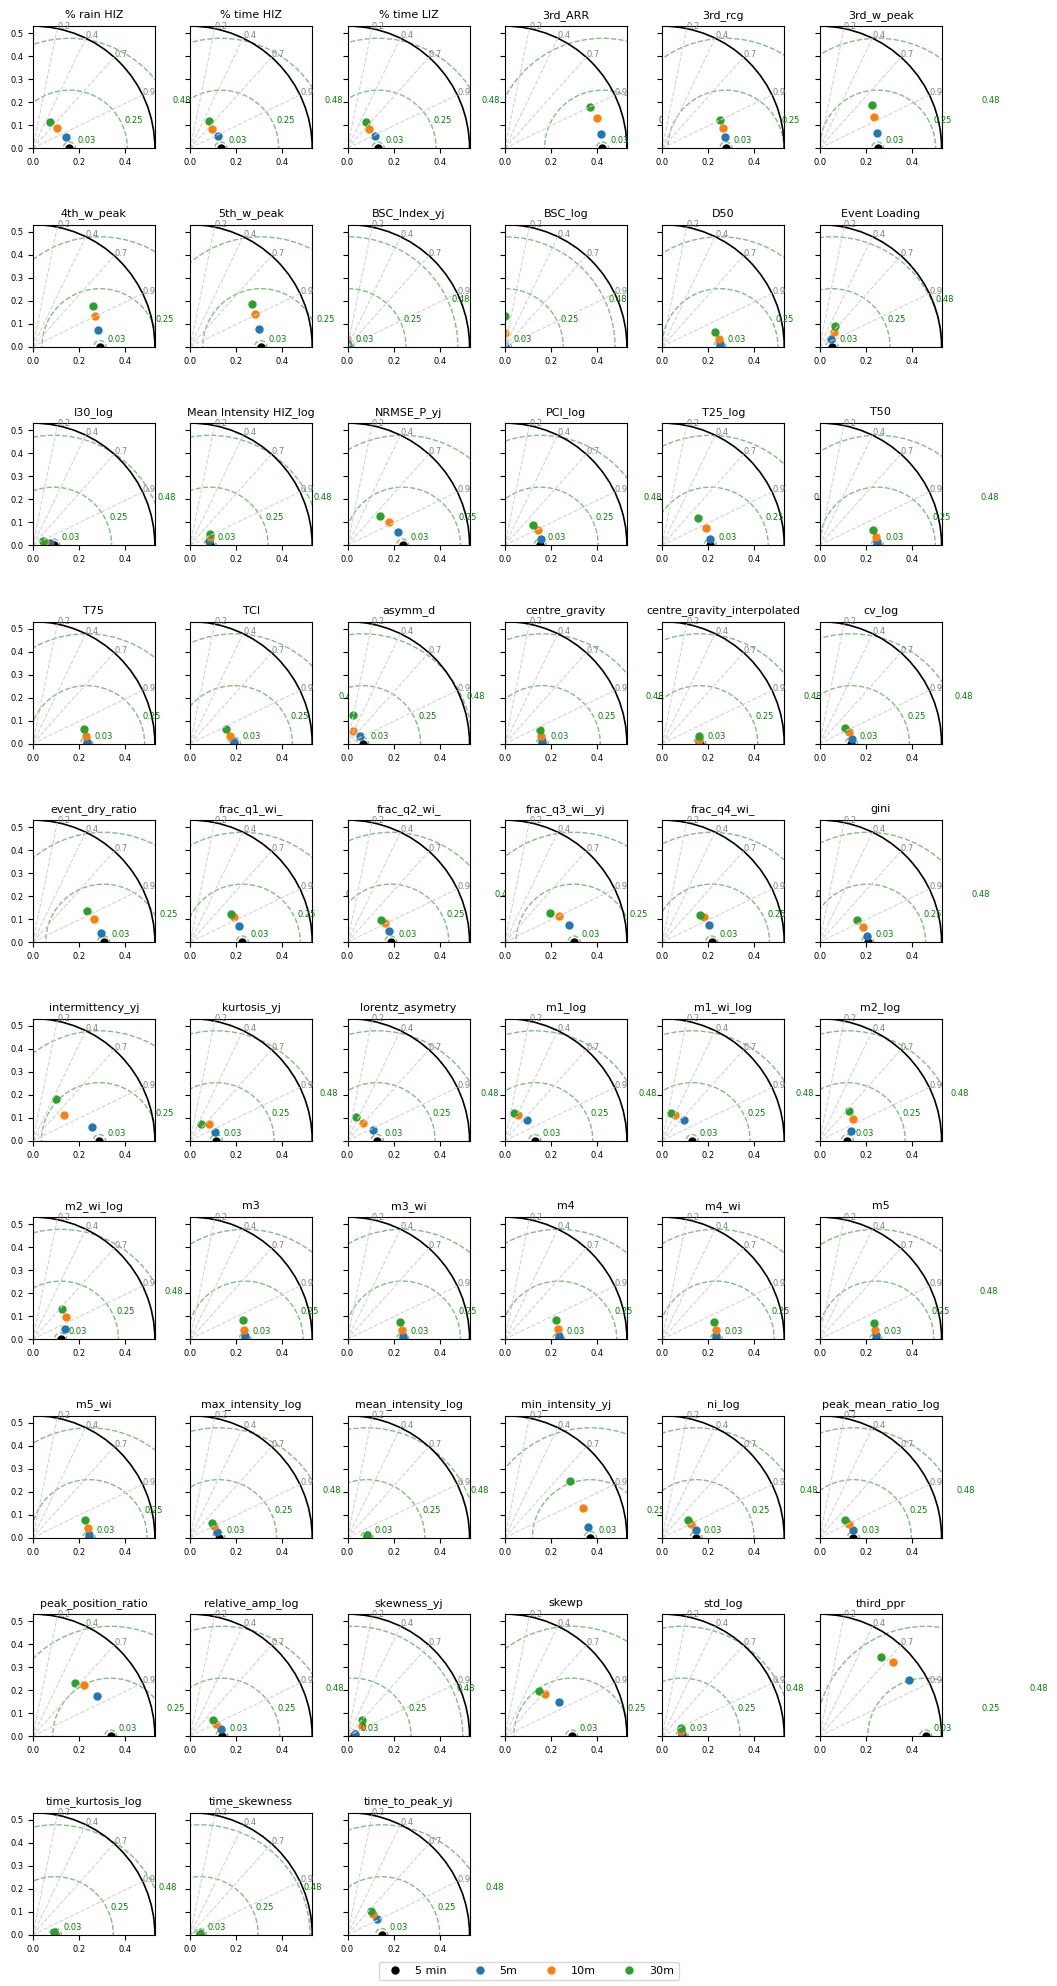

In [303]:
metrics = set()
for col in transformed_minmax_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)
metrics = sorted(metrics)  # Sort for consistent ordering

resolutions = ['5m', '10m', '30m', '60m']
mod_labels = ['5m', '10m', '30m']

# Create 8x8 subplot grid
fig, axs = plt.subplots(10, 6, figsize=(10, 20), sharey=True)
axs = axs.flatten()

plot_fixedscale_taylor(transformed_minmax_scaled, metrics, resolutions, axs, mod_labels=mod_labels, point_size=5)

# Hide unused axes
for ax in axs[len(metrics):]:
    ax.axis('off')

# Add legend BEFORE tight_layout
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(mod_labels)+1, fontsize=8)

# Reserve space at bottom for legend
plt.subplots_adjust(wspace=-0.4, hspace=0.4, bottom=0.1)  # Try bottom=0.1–0.2

plt.tight_layout()
fig.savefig("ByMetric.png")
plt.show()

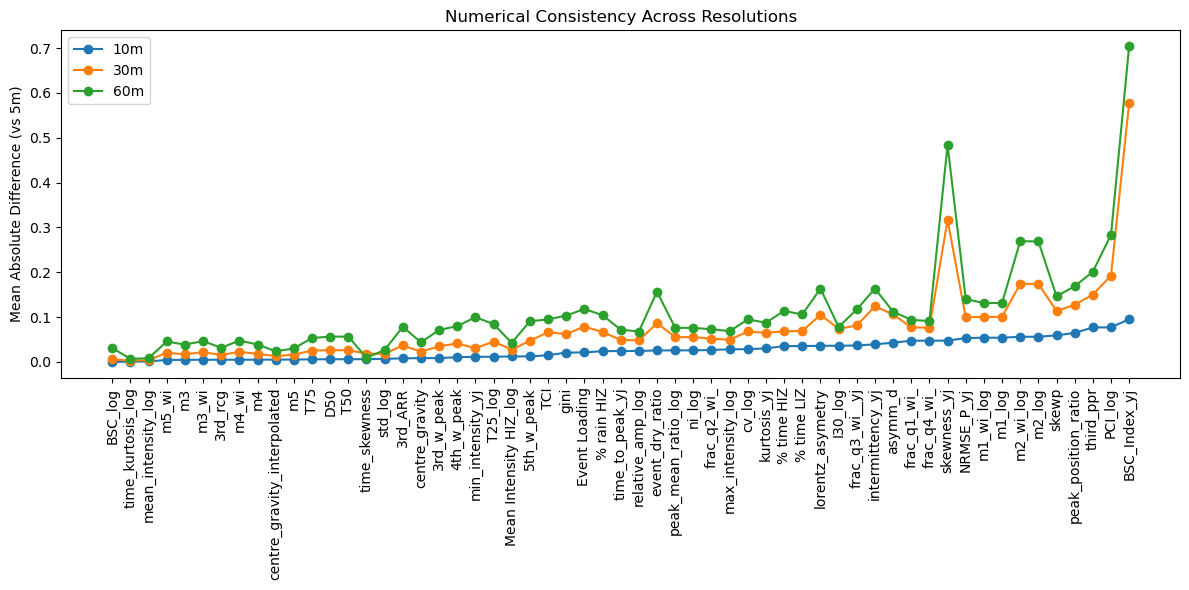

In [351]:
metrics = set()
for col in transformed_minmax_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)
metrics = sorted(metrics)  # Sort for consistent ordering

def compute_mad_relative_to_5m(df, metrics, resolutions):
    mad_results = {res: [] for res in resolutions if res != '5m'}
    for metric in metrics:
        ref = df[f"{metric}_5m"]
        for res in mad_results:
            if f"{metric}_{res}" in df.columns:
                diff = np.abs(df[f"{metric}_{res}"] - ref)
                mad_results[res].append(diff.mean())
            else:
                mad_results[res].append(np.nan)
    return pd.DataFrame(mad_results, index=metrics)

# Example usage
resolutions = ['5m', '10m', '30m', '60m']
mad_df = compute_mad_relative_to_5m(transformed_minmax_scaled, metrics, resolutions)
mad_df.sort_values(by='10m', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
for res in mad_df.columns:
    plt.plot(mad_df.index, mad_df[res], marker='o', label=res)
plt.xticks(rotation=90)
plt.ylabel('Mean Absolute Difference (vs 5m)')
plt.title('Numerical Consistency Across Resolutions')
plt.legend()
plt.tight_layout()
plt.show()


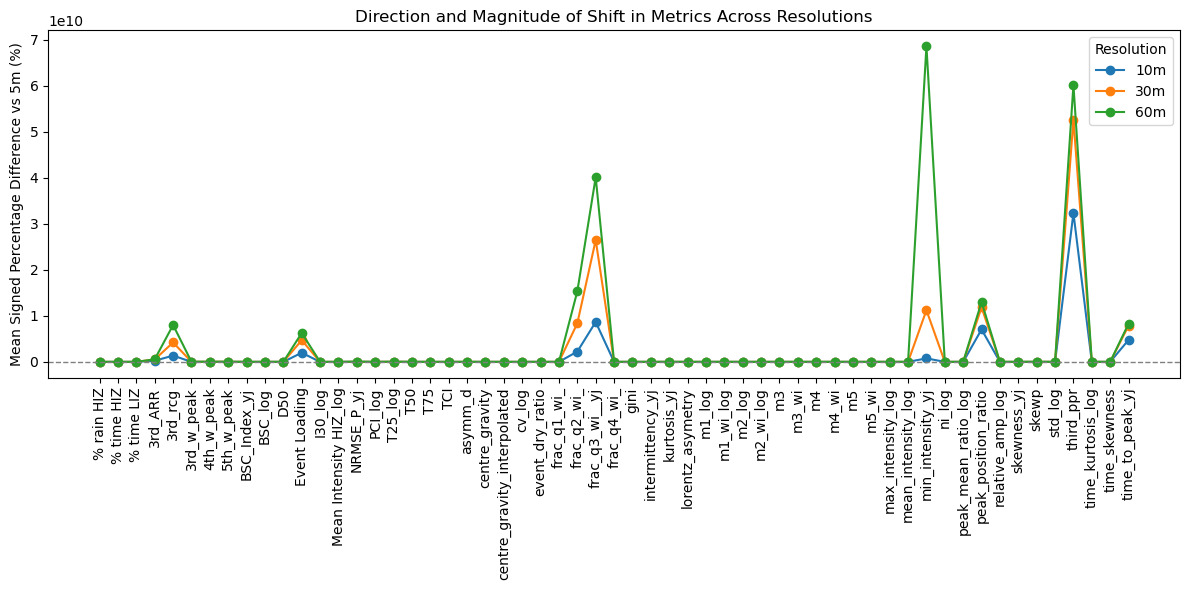

In [356]:
def compute_signed_pct_diff_relative_to_5m(df, metrics, resolutions):
    """
    Compute mean signed percentage difference relative to 5m baseline for each metric and resolution.
    Positive values mean the metric at that resolution is on average higher than 5m,
    negative values mean it is lower.
    
    Returns a DataFrame with mean signed percentage differences (%).
    """
    pct_diff_results = {res: [] for res in resolutions if res != '5m'}
    
    for metric in metrics:
        ref = df[f"{metric}_5m"]
        for res in pct_diff_results:
            col = f"{metric}_{res}"
            if col in df.columns:
                # Avoid division by zero by adding a small epsilon
                epsilon = 1e-10
                # Calculate signed percentage difference: ((value - ref) / ref) * 100
                signed_pct_diff = ((df[col] - ref) / (ref + epsilon)) * 100
                pct_diff_results[res].append(signed_pct_diff.mean())
            else:
                pct_diff_results[res].append(np.nan)
    
    return pd.DataFrame(pct_diff_results, index=metrics)
    
resolutions = ['5m', '10m', '30m', '60m']

    
# Example usage
pct_diff_df = compute_signed_pct_diff_relative_to_5m(transformed_minmax_scaled, metrics, resolutions)

plt.figure(figsize=(12, 6))
for res in pct_diff_df.columns:
    plt.plot(pct_diff_df.index, pct_diff_df[res], marker='o', label=res)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=90)
plt.ylabel('Mean Signed Percentage Difference vs 5m (%)')
plt.title('Direction and Magnitude of Shift in Metrics Across Resolutions')
plt.legend(title='Resolution')
plt.tight_layout()
plt.show()


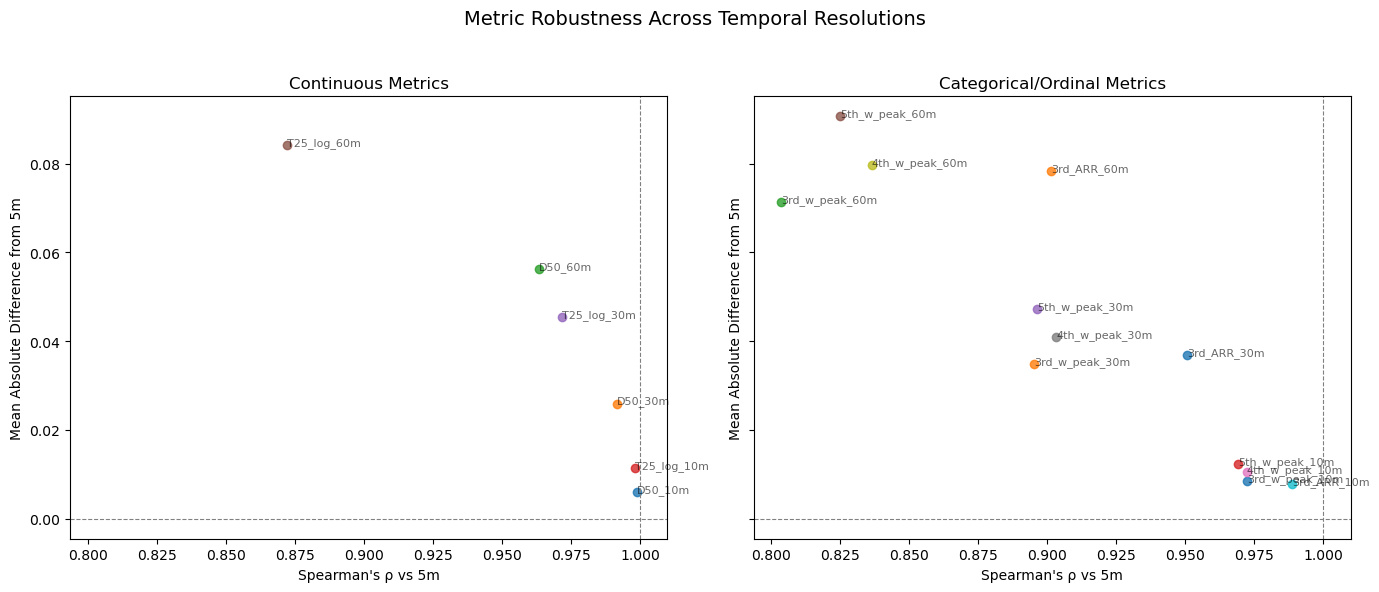

In [416]:
import matplotlib.pyplot as plt

# Example metric groups


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def plot_mad_vs_spearman(df, continuous_metrics, categorical_metrics, resolutions=['10m', '30m', '60m']):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    for ax, metric_group, title in zip(
        axes,
        [continuous_metrics, categorical_metrics],
        ["Continuous Metrics", "Categorical/Ordinal Metrics"]
    ):
        for metric in metric_group:
            ref_col = f"{metric}_5m"
            if ref_col not in df.columns:
                continue
            ref_vals = df[ref_col]

            for res in resolutions:
                col = f"{metric}_{res}"
                if col not in df.columns:
                    continue
                comp_vals = df[col]

                # Drop NA pairs
                valid = ref_vals.notna() & comp_vals.notna()
                x = ref_vals[valid]
                y = comp_vals[valid]

                if len(x) < 2:
                    continue

                # Calculate Spearman correlation and MAD
                rho, _ = spearmanr(x, y)
                mad = np.mean(np.abs(y - x))

                ax.scatter(rho, mad, label=f"{metric}_{res}", alpha=0.8)
                ax.text(rho, mad, f"{metric}_{res}", fontsize=8, alpha=0.6)

        ax.axvline(1.0, color='gray', linestyle='--', linewidth=0.8)
        ax.axhline(0.0, color='gray', linestyle='--', linewidth=0.8)
        ax.set_title(title)
        ax.set_xlabel("Spearman's ρ vs 5m")
        ax.set_ylabel("Mean Absolute Difference from 5m")

    plt.suptitle("Metric Robustness Across Temporal Resolutions", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

continuous_metrics = ["skewness", "D50", "T25_log", 'kurtosis']
categorical_metrics = ["3rd_w_peak", "5th_w_peak", '4th_w_peak', '3rd_ARR']


plot_mad_vs_spearman(df=transformed_minmax_scaled,
                     continuous_metrics=continuous_metrics,
                     categorical_metrics=categorical_metrics,
                     resolutions=['10m', '30m', '60m'])


30 [-0.07176095 -0.50965044]
31 [0.77151076 0.73124884]
32 [-0.39725884 -0.1661833 ]
33 [-0.45731667 -0.06439255]


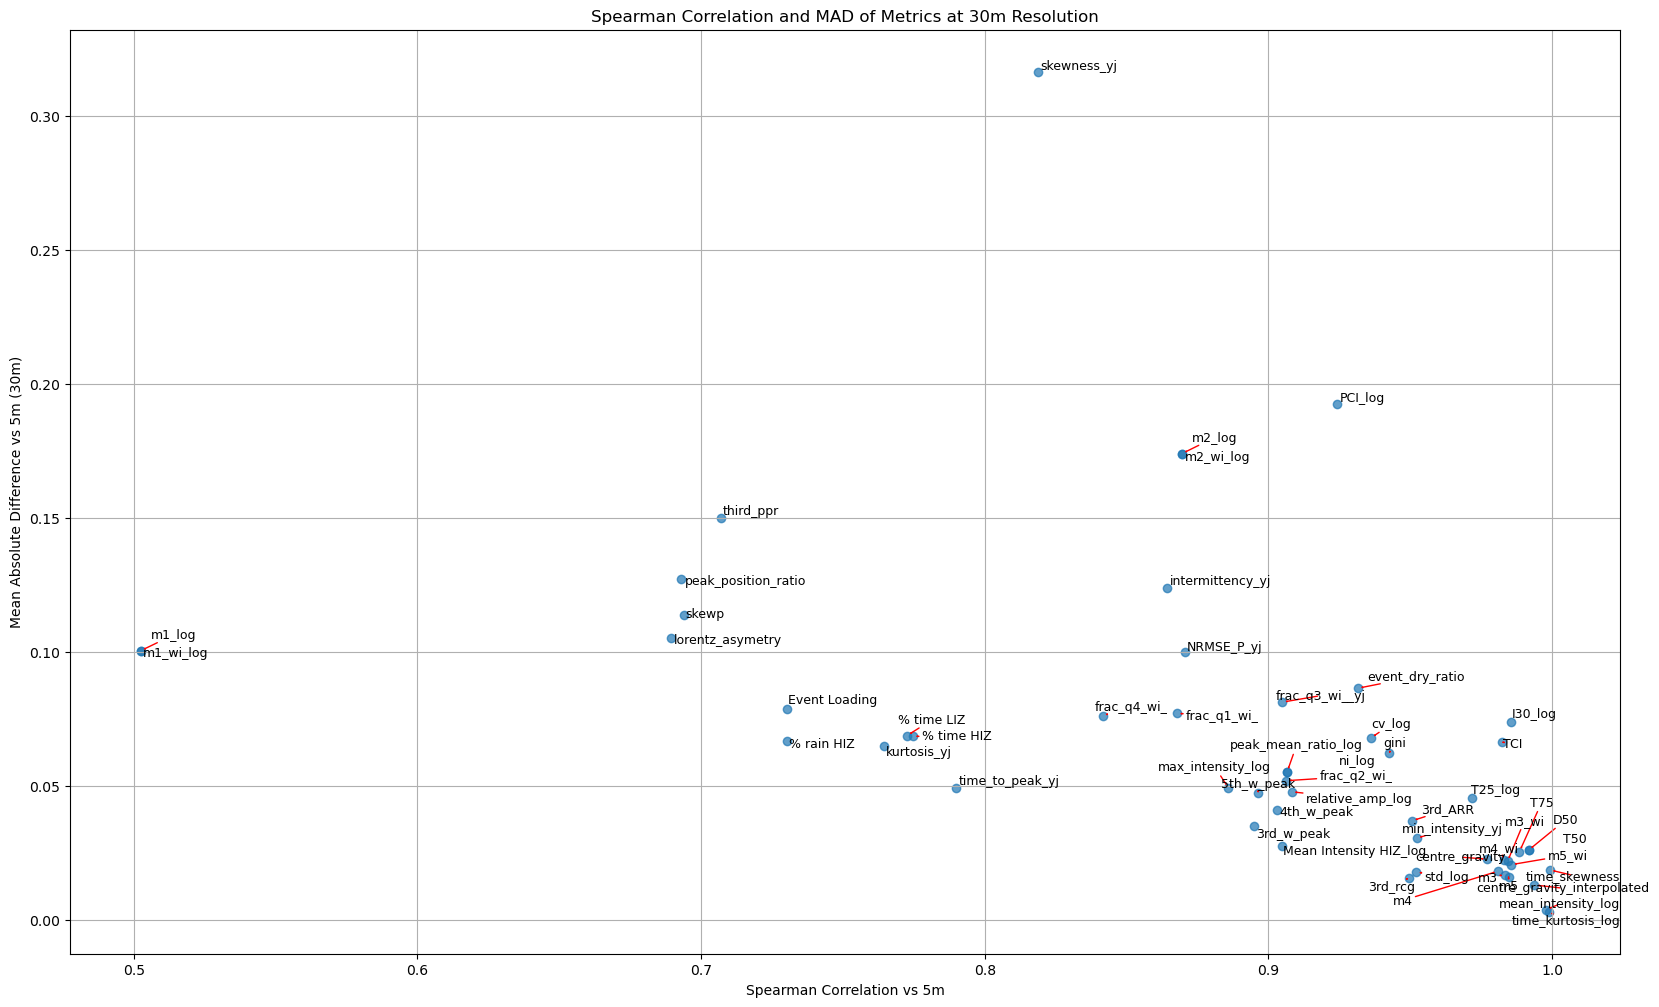

In [395]:
from adjustText import adjust_text

plt.figure(figsize=(20, 12))
plt.scatter(results_df['spearman_rho'], results_df['mad'], alpha=0.7)


plt.xlabel('Spearman Correlation vs 5m')
plt.ylabel(f'Mean Absolute Difference vs 5m ({res_to_plot})')
plt.title(f'Spearman Correlation and MAD of Metrics at {res_to_plot} Resolution')
plt.grid(True)
plt.show()


2720790.963501377
138605.0322879307
106969.28639006462
561130284.8985987
8001251228.603787
21951317.166882064
21951321.60516185
18521434.578818455
5454132.523445931
6270347872.364447
461478.33978803275
35429.03064619493
38852204.39722891
177190.44310223954
28288227.103793178
5454132.523445931
311008.6979297479
68377.14883122925
10.25223069614719
10810.611675114578
422921.44020832155
29.992626250951197
13840.28804804378
15335507582.413017
40101254759.44435
515220.1406934616
550813.3534558786
27.920800504835086
1611619.3116836445
22.994762278297607
339036.1459444335
339036.1459444335
290.59482970449835
290.59482970449835
5539.499944730533
19.991806404435934
4618.5523054535815
22.500458636895733
7.443493610767674
15.431875644097042
124242.39033088772
6.316508716622995
68587408146.49042
108940.47279848982
108940.47279848982
13008168913.89209
418572.9414929172
348455.28085947235
7164818.511797849
47016.336896603374
60138348126.08268
7.564511189986776
327676.0379576202
8298860668.3162365
32 

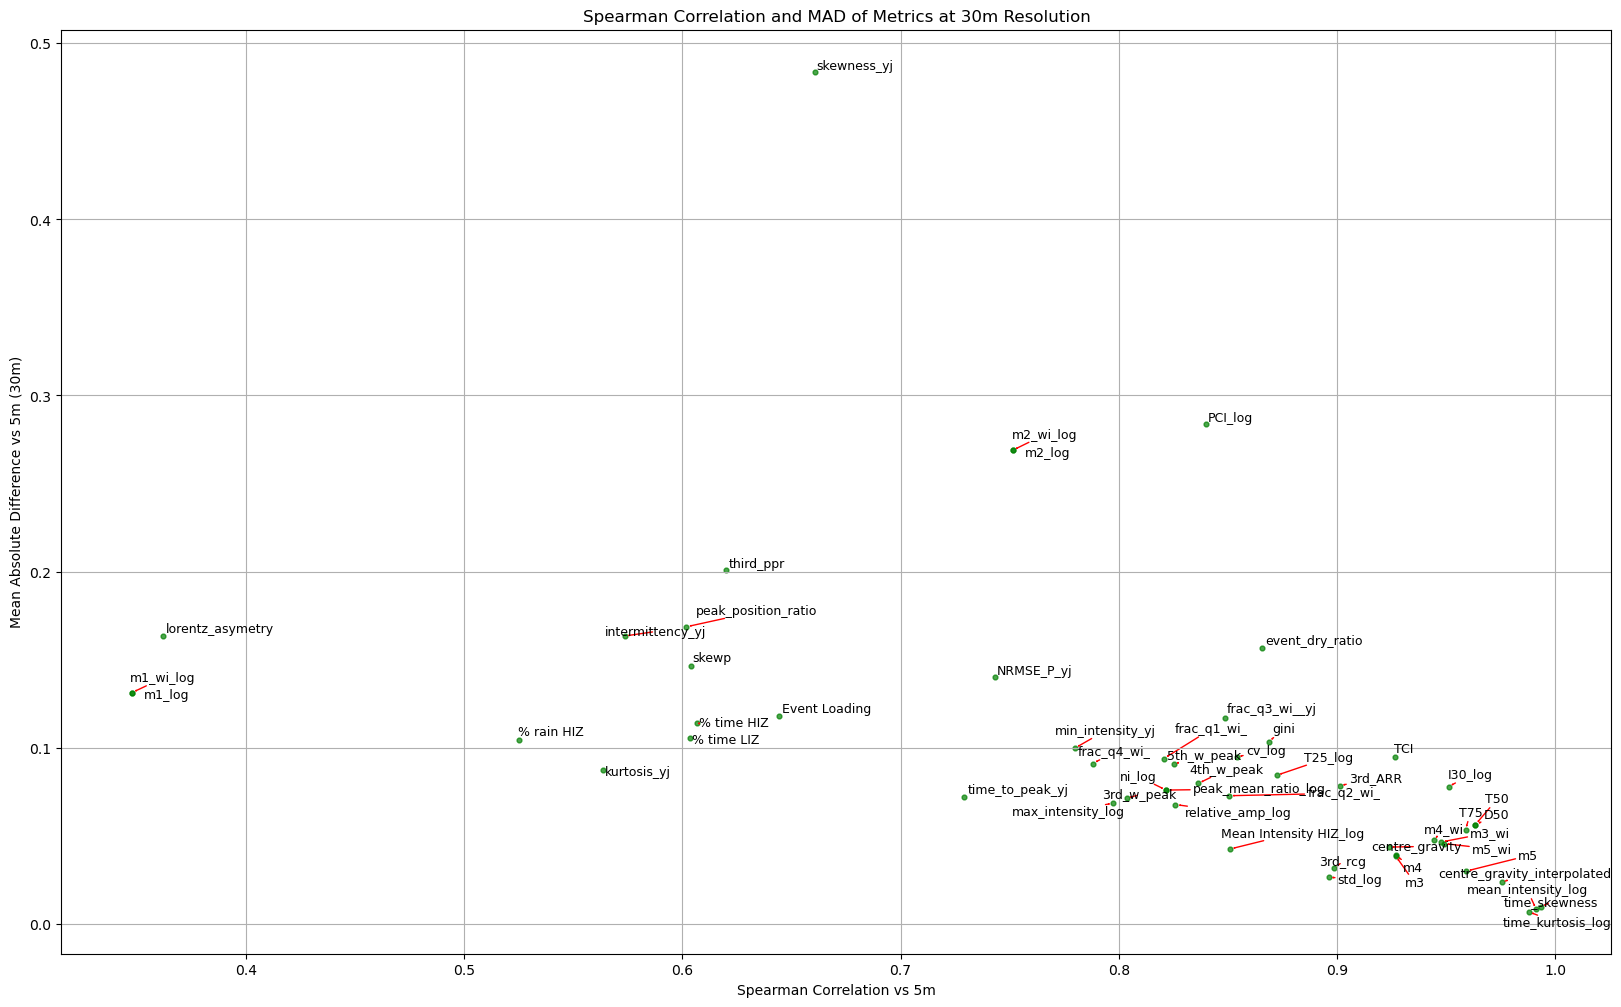

In [403]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def spearman_vs_mad(df, metrics, resolution):
    results = []
    ref_suffix = '_5m'
    res_suffix = f"_{resolution}"
    
    for metric in metrics:
        if metric not in ['BSC_log', 'BSC_Index_yj', 'asymm_d']:
            col_ref = metric + ref_suffix
            col_res = metric + res_suffix
            if col_res in df.columns and col_ref in df.columns:
                ref_vals = df[col_ref].values
                res_vals = df[col_res].values
                
                # Filter out NaNs (important if present)
                mask = ~np.isnan(ref_vals) & ~np.isnan(res_vals)
                if mask.sum() == 0:
                    continue
                
                ref_vals = ref_vals[mask]
                res_vals = res_vals[mask]
                
                # Calculate Spearman correlation
                rho, _ = spearmanr(ref_vals, res_vals)
                
                # Calculate mean absolute difference
                mad = np.mean(np.abs(res_vals - ref_vals))
                epsilon = 1e-10
                mape = np.mean(np.abs((res_vals - ref_vals) / (ref_vals + epsilon))) * 100
                print(mape)

                results.append({'metric': metric, 'spearman_rho': rho, 'mad': mad})
        
    return pd.DataFrame(results)

# Example usage for 30m resolution
results_df_60m = spearman_vs_mad(transformed_minmax_scaled, metrics, '60m')
# results_df_30m = spearman_vs_mad(transformed_minmax_scaled, metrics, '30m')
# results_df_10m = spearman_vs_mad(transformed_minmax_scaled, metrics, '10m')

plt.figure(figsize=(20, 12))
# plt.scatter(results_df_10m['spearman_rho'], results_df_10m['mad'], alpha=0.7, s=12,color='darkblue')
# plt.scatter(results_df_30m['spearman_rho'], results_df_30m['mad'], alpha=0.7, s=12,color='red')
plt.scatter(results_df_60m['spearman_rho'], results_df_60m['mad'], alpha=0.7, s=12,color='green')

texts = []
for i, row in results_df_60m.iterrows():
    texts.append(plt.text(row['spearman_rho'], row['mad'], row['metric'], fontsize=9))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# plt.xlim(0.4, 1)
# plt.ylim(0, 0.5)
plt.xlabel('Spearman Correlation vs 5m')
plt.ylabel(f'Mean Absolute Difference vs 5m ({res_to_plot})')
plt.title(f'Spearman Correlation and MAD of Metrics at {res_to_plot} Resolution')
plt.grid(True)
plt.show()


In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_pct_diff_long(df, metrics, resolutions):
    """
    Compute signed percentage difference relative to 5m baseline for each metric and resolution.
    Returns a long-format DataFrame with columns: ['metric', 'resolution', 'pct_diff'].
    """
    records = []
    epsilon = 1e-10

    for metric in metrics:
        ref = df[f"{metric}_5m"]
        for res in resolutions:
            if res == '5m':
                continue  # skip baseline
            col = f"{metric}_{res}"
            if col in df.columns:
                pct_diff = ((df[col] - ref) / (ref + epsilon)) * 100
                for val in pct_diff:
                    records.append({'metric': metric, 'resolution': res, 'pct_diff': val})

    return pd.DataFrame(records)

# Compute long format pct diff
pct_diff_long = compute_pct_diff_long(transformed_minmax_scaled, metrics, resolutions)

# Plot violin plots of percentage differences by resolution for each metric
plt.figure(figsize=(16, 10))
g = sns.catplot(
    data=pct_diff_long, x='resolution', y='pct_diff', col='metric',
    kind='violin', sharey=False, height=4, aspect=1
)
g.set_titles("{col_name}")
g.set_axis_labels("Resolution", "Signed % Difference vs 5m")
for ax in g.axes.flatten():
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()



KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f50cc793ba0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



<Figure size 1600x1000 with 0 Axes>

Error in callback <function flush_figures at 0x7f507f7bf600> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



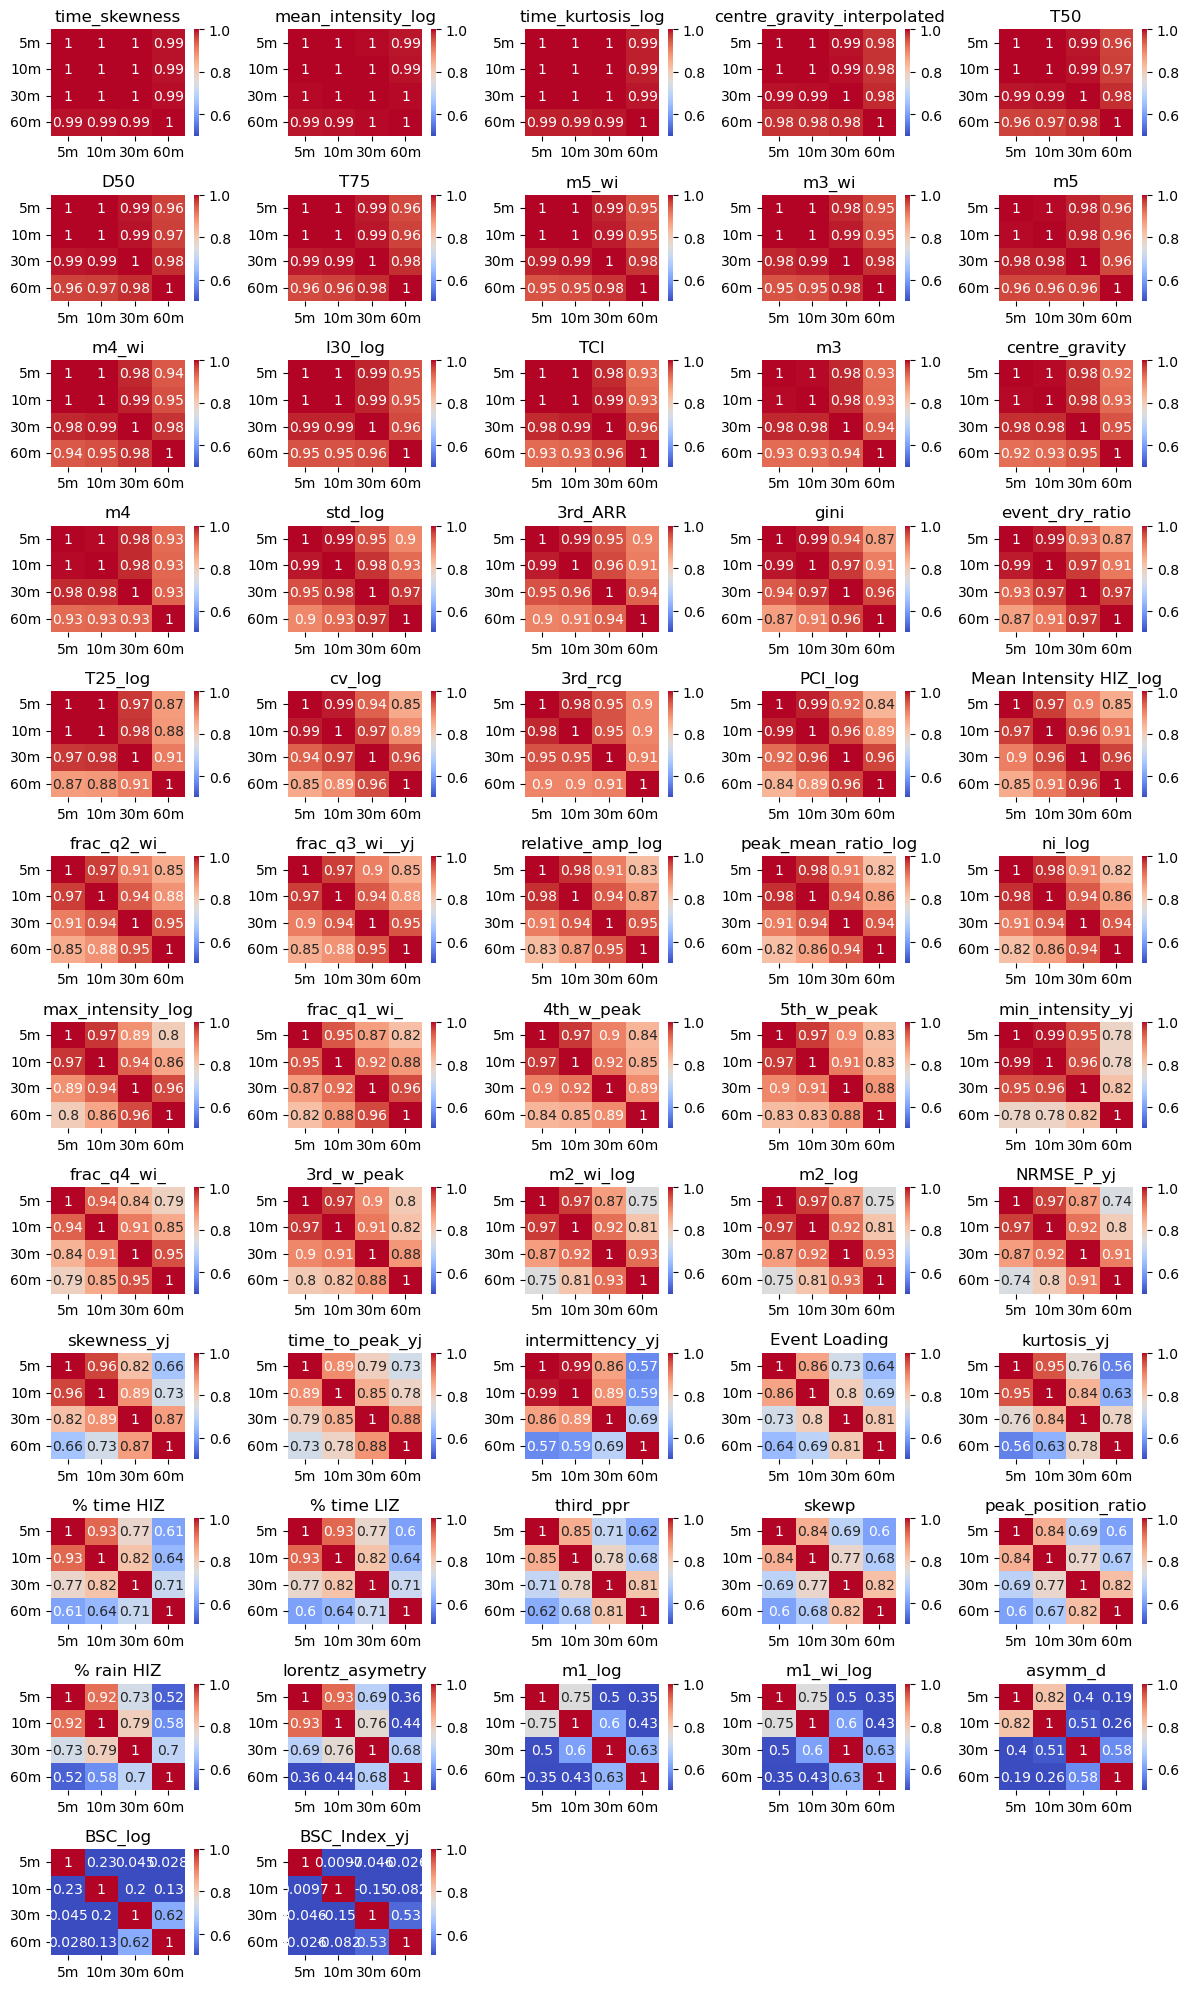

In [341]:
# Step 1: Extract unique metrics from column names
metrics = set()
for col in transformed_minmax_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)

# Step 2: Compute average Spearman correlation for each metric
metric_corrs = []
for metric in metrics:
    try:
        # Create a DataFrame with all resolutions of this metric
        data = pd.DataFrame({
            res: transformed_minmax_scaled[f"{metric}_{res}"] for res in resolutions
        })

        corr_matrix = data.corr(method='spearman')
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        mean_corr = upper_tri.stack().mean()  # average of upper triangle (pairwise correlations)
        metric_corrs.append((metric, mean_corr))
    except KeyError:
        continue  # Skip metric if any resolution is missing

# Step 3: Sort metrics by descending average correlation
sorted_metrics = [m for m, _ in sorted(metric_corrs, key=lambda x: -x[1])]

# Step 4: Plot heatmaps with sorted metric order
fig, axs = plt.subplots(12, 5, figsize=(12, 20))
axs = axs.flatten()

for i, metric in enumerate(sorted_metrics):
    try:
        data = pd.DataFrame({
            res: transformed_minmax_scaled[f"{metric}_{res}"] for res in resolutions
        })
        corr = data.corr(method='spearman')
        sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axs[i], vmin=0.5, vmax=1)
        axs[i].set_title(f"{metric}")
    except KeyError:
        axs[i].axis('off')  # In case of missing data

# Hide any extra axes
for j in range(len(sorted_metrics), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


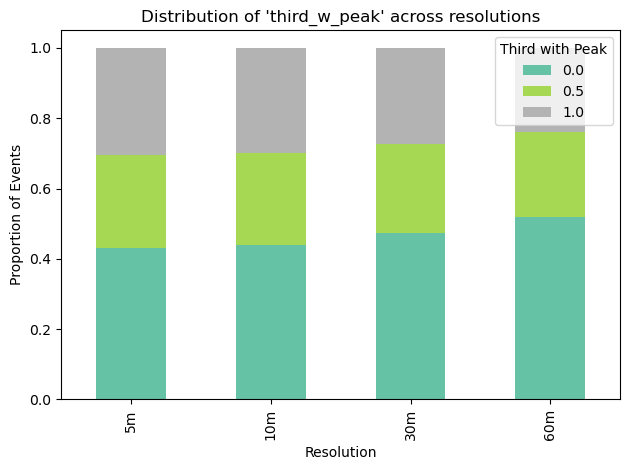

In [314]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: column names like "third_w_peak_5m", "third_w_peak_10m", etc.
metric_base = "3rd_ARR"
resolutions = ["5m", "10m", "30m", "60m"]
df = transformed_minmax_scaled

# Count values
value_counts = pd.DataFrame({
    res: df[f"{metric_base}_{res}"].value_counts(normalize=True)  # % per category
    for res in resolutions
}).fillna(0)

# Plot
value_counts.T.plot(kind='bar', stacked=True, colormap='Set2')
plt.title("Distribution of 'third_w_peak' across resolutions")
plt.ylabel("Proportion of Events")
plt.xlabel("Resolution")
plt.legend(title="Third with Peak")
plt.tight_layout()
plt.show()


0.04342710042360202


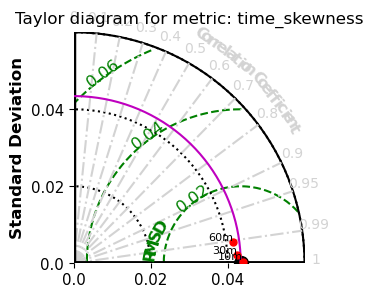

In [270]:
plot_one_metric_sm('time_skewness', transformed_minmax_scaled)

0.09756814768591966


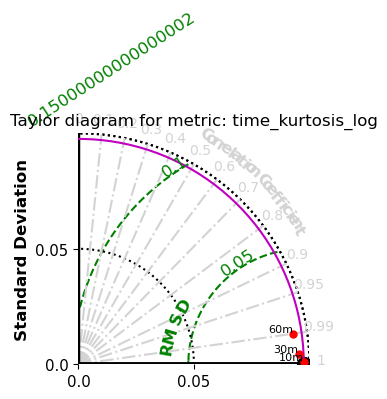

In [267]:
plot_one_metric_sm('time_kurtosis_log', transformed_minmax_scaled)

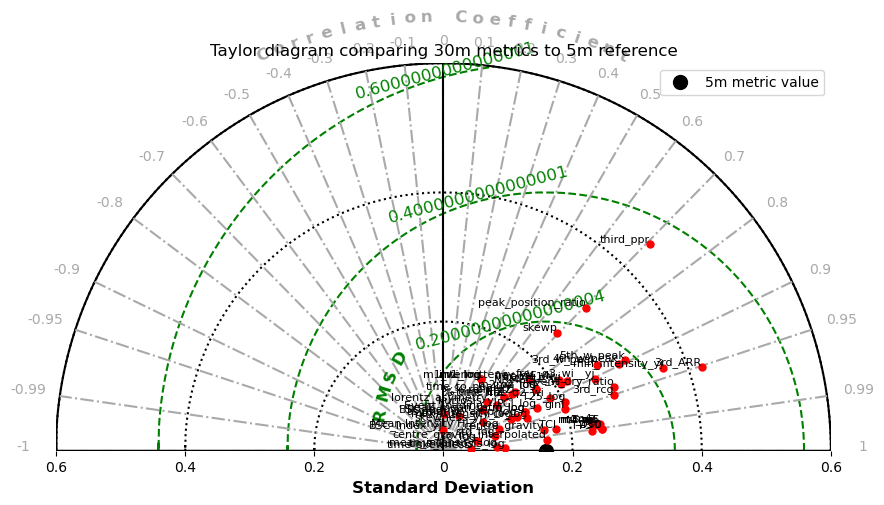

In [230]:
plot_taylor_all_metrics(transformed_minmax_scaled)

In [377]:
del transformed_standard_scaled['BSC_log_5m']
del transformed_standard_scaled['BSC_log_30m']
del transformed_standard_scaled['BSC_Index_yj_5m']
del transformed_standard_scaled['BSC_Index_yj_30m']
del transformed_standard_scaled['intermittency_yj_5m']
del transformed_standard_scaled['intermittency_yj_30m']

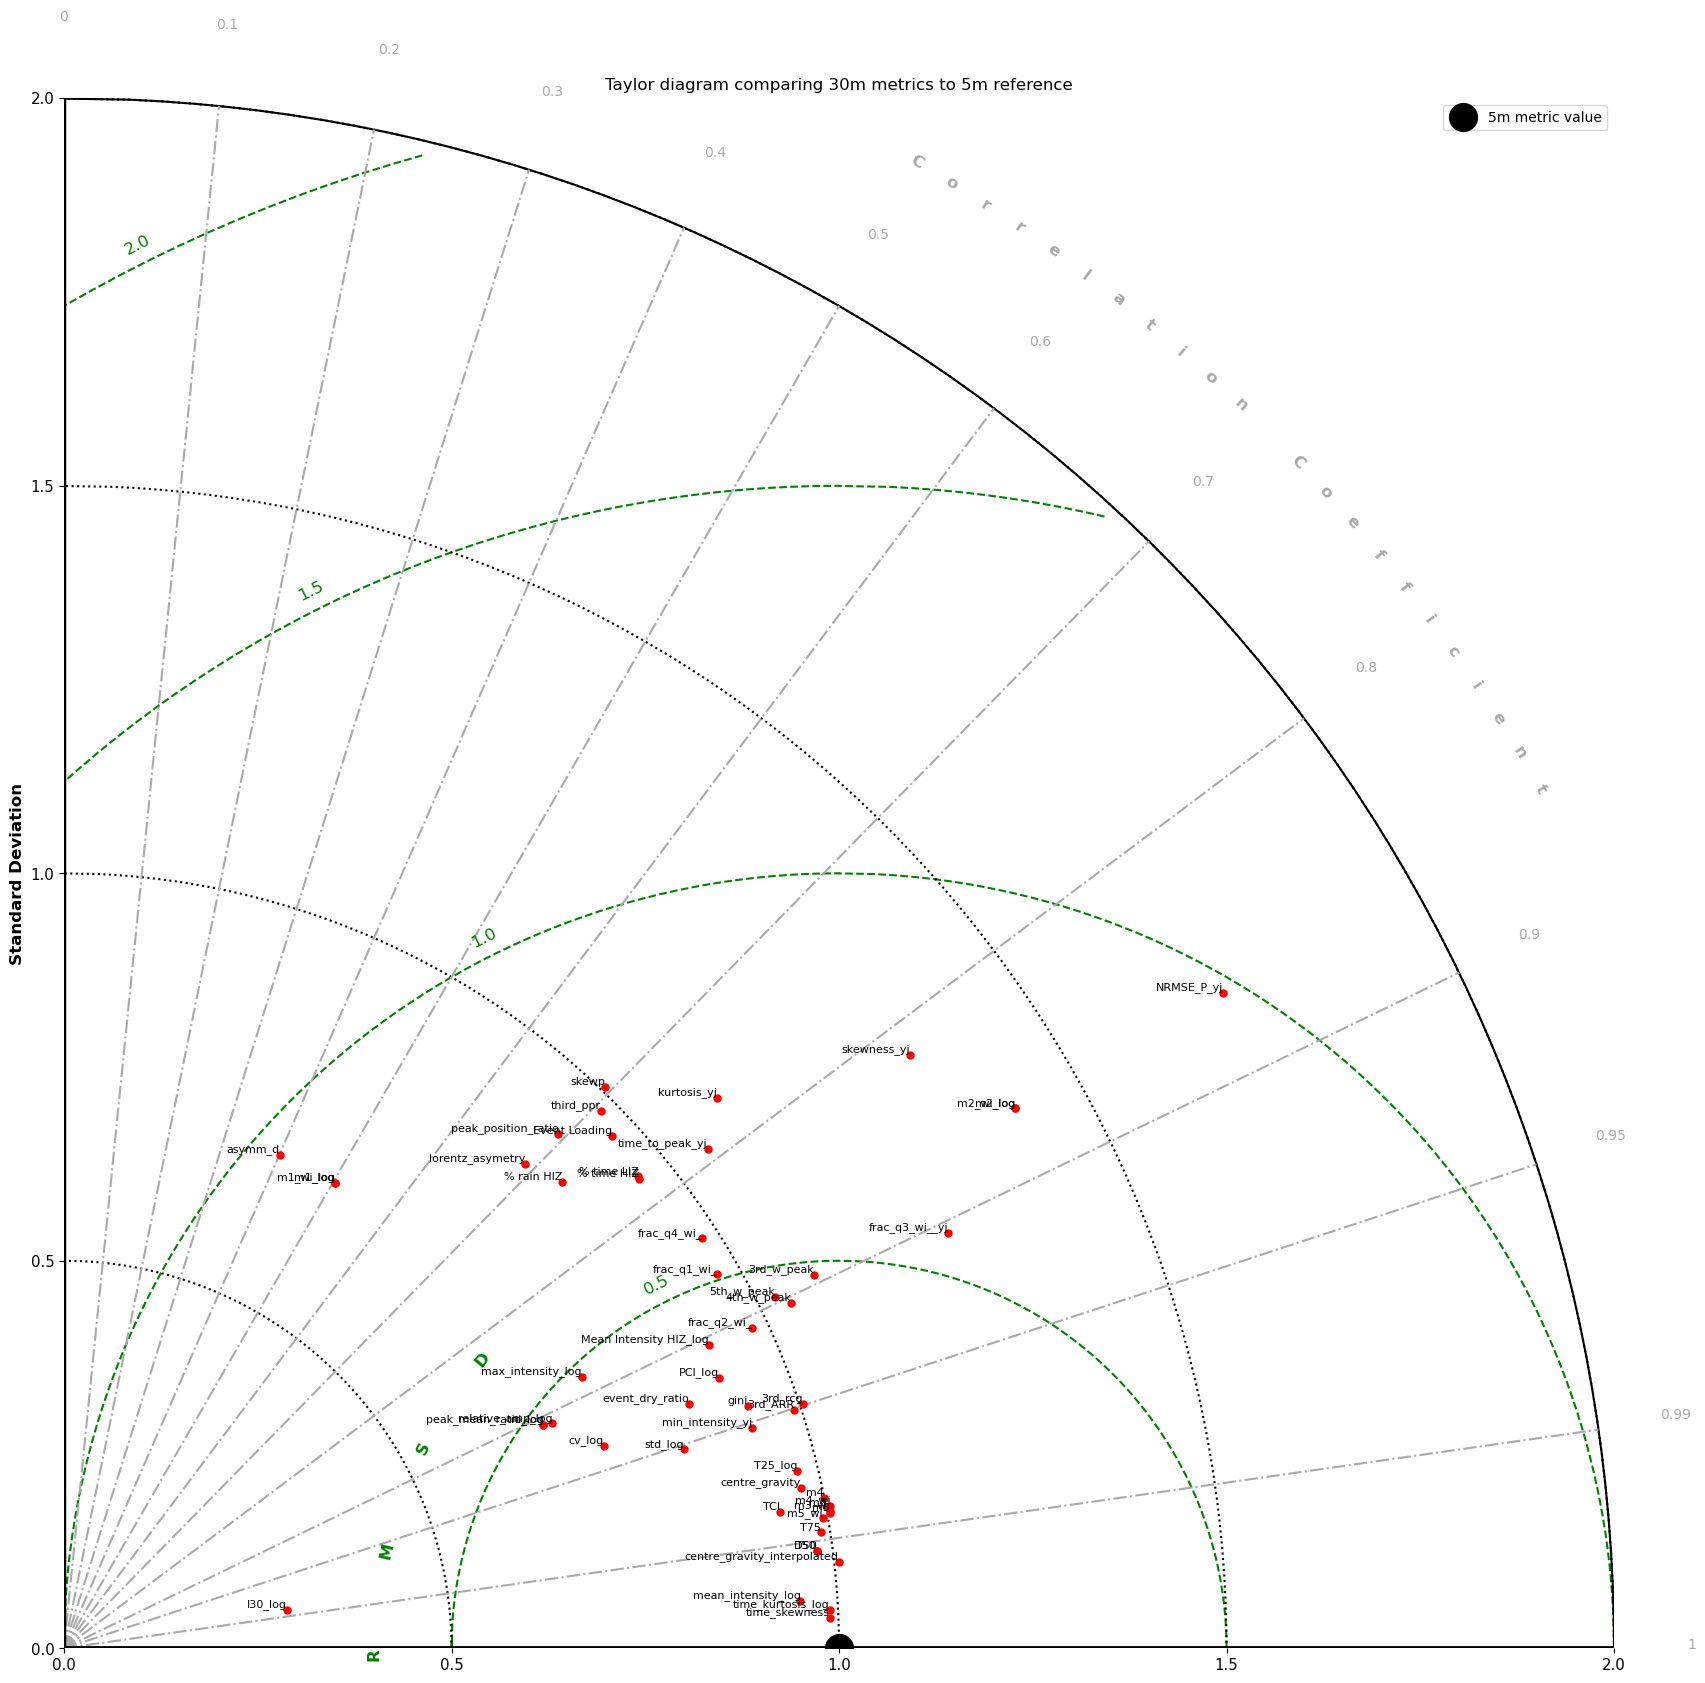

In [378]:
plot_taylor_all_metrics(transformed_standard_scaled)

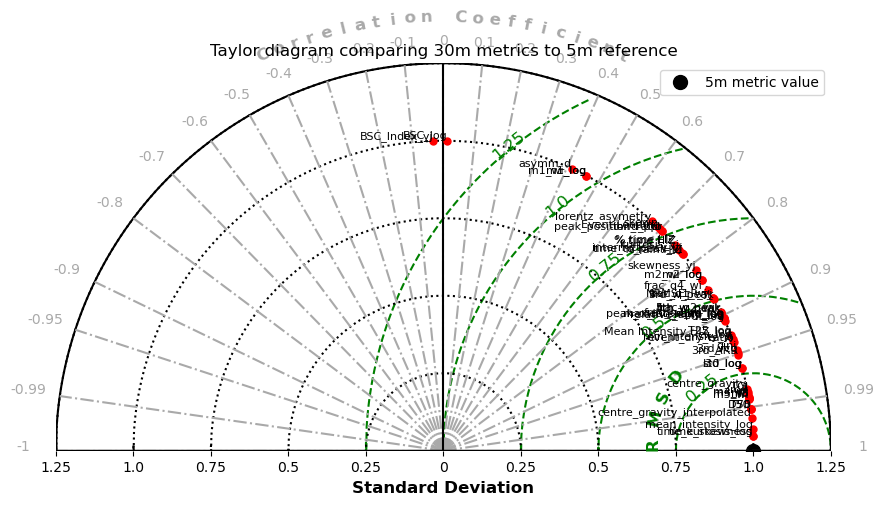

In [229]:
plot_taylor_all_metrics(transformed_standard_scaled)

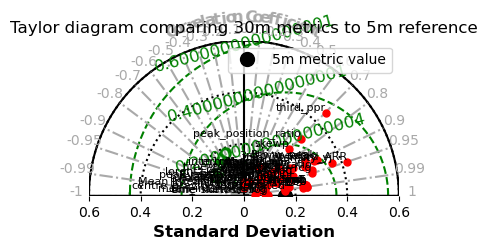

In [256]:
# --- Identify unique metric names (e.g., 't50', '3rd_w_Peak') --- #
metrics = set()
for col in transformed_minmax_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)
metrics = sorted(metrics)  # Sort for consistent ordering

# --- Prepare arrays to hold statistics --- #
std_ref_all = []   # Standard deviations of reference (5m) metrics
rms_ref_all = []   # RMSD of reference points (always 0)
corr_ref_all = []  # Correlation of reference points (always 1)

stds = []   # STD of 30m values
rmsds = []  # Centered RMSD between 30m and 5m
cors = []   # Pearson correlation coefficients
labels = [] # Metric names for labeling

# --- Loop through first 10 metrics and compute comparison statistics --- #
for metric in metrics:  # Limit to 10 metrics for clarity
    col_5m = f"{metric}_5m"
    col_30m = f"{metric}_30m"

    # Check both columns exist
    if col_5m in transformed_minmax_scaled.columns and col_30m in transformed_minmax_scaled.columns:
        ref = transformed_minmax_scaled[col_5m].values
        mod = transformed_minmax_scaled[col_30m].values

        # Mask to drop any NaN values
        mask = ~np.isnan(ref) & ~np.isnan(mod)
        ref = ref[mask]
        mod = mod[mask]

        if len(ref) > 1:
            # Compute stats
            std_ref = np.std(ref, ddof=1)  # standard deviation of reference
            std_mod = np.std(mod, ddof=1)  # standard deviation of model
            corr = np.corrcoef(ref, mod)[0,1]  # Pearson correlation
            rmsd_centered = np.sqrt(np.mean(((mod - np.mean(mod)) - (ref - np.mean(ref)))**2))

            # Append reference stats
            std_ref_all.append(std_ref)
            rms_ref_all.append(0)  # ref has 0 RMSD
            corr_ref_all.append(1) # ref has perfect correlation

            # Append model stats
            stds.append(std_mod)
            rmsds.append(rmsd_centered)
            cors.append(corr)
            labels.append(metric)  # label with metric name

# --- Compose input arrays in required format for skill_metrics --- #
# Reference must be first in all arrays
STDs = np.array([std_ref_all[0]] + stds)   # reference std + model stds
RMSs = np.array([0] + rmsds)               # reference RMS (0) + model RMSs
CORs = np.array([1] + cors)                # reference correlation (1) + model corrs

# --- Optional: manually plot the reference point for clarity --- #
ref_std = STDs[0]  # Reference standard deviation (used for locating the black dot)

# Create plot
plt.figure(figsize=(4,5))

# Manually add black dot for reference point at angle 0° (horizontal)
plt.plot(ref_std, 0, 'ko', label='5m metric value', markersize=10)

# --- Call Taylor diagram plotting function --- #
sm.taylor_diagram(STDs, RMSs, CORs, markerLabel=['5m_ref'] + labels,  
    colCOR='darkgray',   styleRMS='--', colRMS='green')

# --- Final layout adjustments --- #
plt.title("Taylor diagram comparing 30m metrics to 5m reference")
plt.legend(loc='upper right')  # Add legend for reference dot
plt.show()


In [316]:
for metric in metrics:
    ref = transformed_minmax_scaled[f'{metric}_5m'].dropna()
    print(metric, np.std(ref))
    for res in resolutions:
        if res == '5m': continue
        mod = transformed_minmax_scaled[f'{metric}_{res}'].dropna()
        common = ref.index.intersection(mod.index)

% rain HIZ 0.1583852579484079
% time HIZ 0.1329866686958457
% time LIZ 0.13304215374280762
3rd_ARR 0.42413263214191116
3rd_rcg 0.27627365055945613
3rd_w_peak 0.25236445712520095
4th_w_peak 0.2915112416513127
5th_w_peak 0.3069448825355447
BSC 0.0016583424658790466
BSC_Index 0.002342522690401456
D50 0.25094228166416044
Event Loading 0.05409669587005699
I30 0.01094038260656145
Mean Intensity HIZ 0.00931963034540842
NRMSE_P 0.10079453644636754
PCI 0.06447593437710546
T25 0.21888086794750214
T50 0.25094228166416044
T75 0.2336505076243621
TCI 0.19230696609420397
asymm_d 0.06533359180462946
centre_gravity 0.16256539476938991
centre_gravity_interpolated 0.1630286098758766
cv 0.08021283253317499
event_dry_ratio 0.3078843085478201
frac_q1_wi_ 0.22645273605122726
frac_q2_wi_ 0.18801336015281359
frac_q3_wi_ 0.18256274375832582
frac_q4_wi_ 0.21417240314493405
gini 0.20873896919216897
intermittency 0.09936912368038983
kurtosis 0.017489007549096384
lorentz_asymetry 0.1285443027447981
m1 0.02614247679

0.022215420054358347


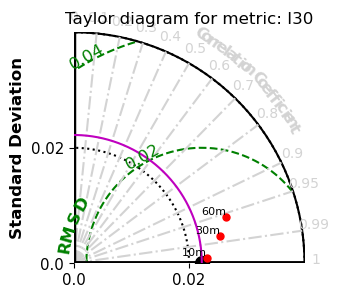

### Cohen's D and Instability

In [18]:
categorical_metric_list = []

for metric in metric_columns:
    unique_vals = all_events_df[metric].dropna().unique()
    if len(unique_vals) < 6:
        categorical_metric_list.append(metric)

print("Detected categorical metrics:", categorical_metric_list)

Detected categorical metrics: ['3rd_w_peak', '4th_w_peak', '5th_w_peak', 'third_ppr', '3rd_ARR', '3rd_rcg']


In [55]:
# print("Metric & Cohen's d\\_10m & Instability\\_10m & Cohen's d\\_30m & Instability\\_30m & Cohen's d\\_60m & Instability\\_60m \\\\")

# for metric in metric_columns:
#     row = [metric]
#     for res in ['10m', '30m', '60m']:
#         metric_fine = transformed_scaled[f"{metric}_5m"]
#         metric_coarse = transformed_scaled[f"{metric}_{res}"]
#         d, meaning = cohens_d(metric_fine, metric_coarse)
#         instab, translation = instability_index(metric_fine, metric_coarse)
        
#         if metric in categorical_metric_list:
#             instab_rank, meaning_rank = ordinal_ranking_instability(metric_fine, metric_coarse)
#             delta, meaning_num = cliffs_delta_fast(metric_fine, metric_coarse)
#             row.append(f"{meaning_rank} ({instab_rank:.2f})")
#             row.append(f"{meaning_num} ({delta:.2f})")
#         else:
#             d, meaning = cohens_d(metric_fine, metric_coarse)
#             instab, translation = instability_index(metric_fine, metric_coarse)
#             row.append(f"{meaning} ({d:.2f})")
#             row.append(f"{translation} ({instab:.2f})")
#     print(" & ".join(row) + " \\\\")


In [24]:
print("Metric & Cohen's d\\_10m & Instability\\_10m & Cohen's d\\_30m & Instability\\_30m & Cohen's d\\_60m & Instability\\_60m \\\\")

for metric in metric_columns:
    row = [metric]
    for res in ['10m', '30m', '60m']:
        metric_fine = transformed_scaled[f"{metric}_5m"]
        metric_coarse = transformed_scaled[f"{metric}_{res}"]
        d, meaning = cohens_d(metric_fine, metric_coarse)
        instab, translation = instability_index(metric_fine, metric_coarse)
        row.append(f"{meaning} ({d:.2f})")
        row.append(f"{translation} ({instab:.2f})")
    print(" & ".join(row) + " \\\\")


Metric & Cohen's d\_10m & Instability\_10m & Cohen's d\_30m & Instability\_30m & Cohen's d\_60m & Instability\_60m \\
3rd_w_peak & Very low (0.03) & Negligible (0.01) \\
3rd_w_peak & Low (0.11) & Negligible (0.03) \\
3rd_w_peak & Moderate (0.21) & Negligible (0.08) \\
4th_w_peak & Very low (0.03) & Negligible (0.01) \\
4th_w_peak & Low (0.12) & Negligible (0.03) \\
4th_w_peak & Moderate (0.20) & Negligible (0.09) \\
5th_w_peak & Very low (0.04) & Negligible (0.01) \\
5th_w_peak & Low (0.13) & Negligible (0.04) \\
5th_w_peak & Moderate (0.22) & Negligible (0.11) \\
third_ppr & Moderate (0.17) & Negligible (0.00) \\
third_ppr & Moderate (0.32) & Negligible (0.04) \\
third_ppr & High (0.41) & Negligible (0.08) \\
3rd_ARR & Very low (0.02) & Negligible (0.01) \\
3rd_ARR & Low (0.07) & Negligible (0.05) \\
3rd_ARR & Low (0.13) & Negligible (0.10) \\
3rd_rcg & Very low (0.02) & Negligible (0.00) \\
3rd_rcg & Low (0.06) & Negligible (0.00) \\
3rd_rcg & Low (0.11) & Negligible (0.00) \\


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


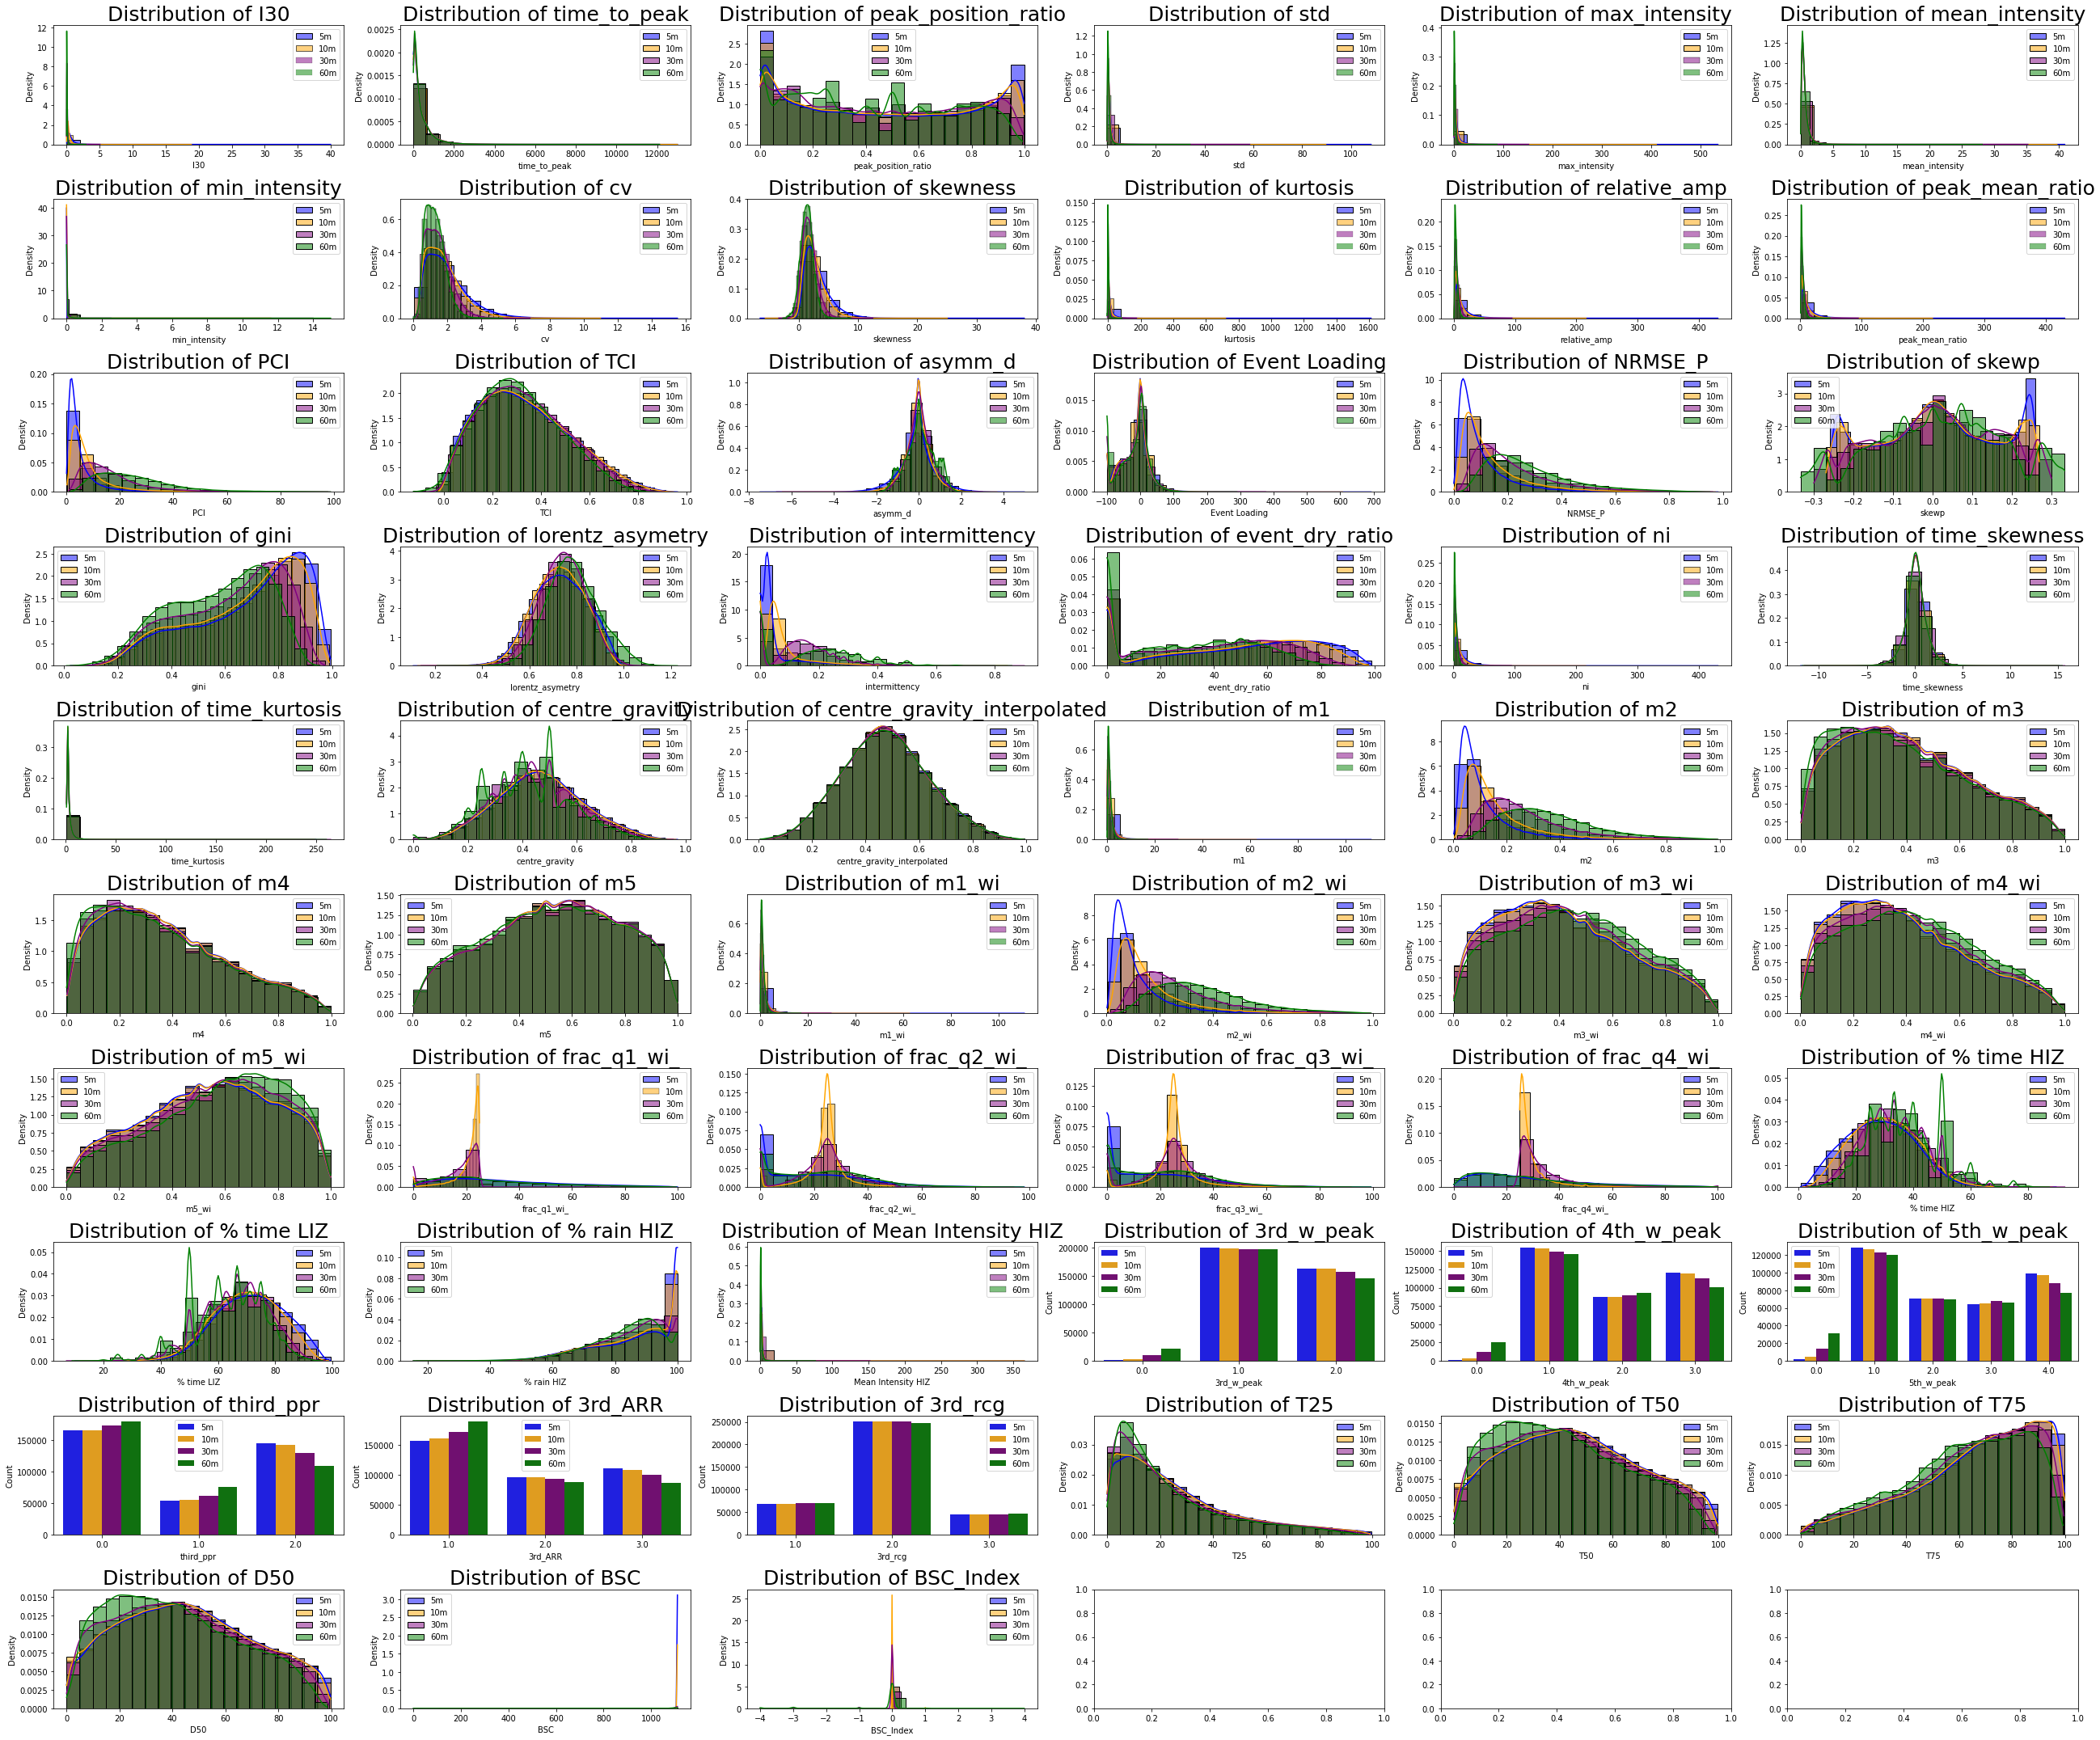

In [215]:
n_metrics = len(metric_columns)

# Define grid shape (e.g., 6 columns per row)
n_cols = 6
n_rows = int(np.ceil(n_metrics / n_cols))

# Define label order and consistent palette
label_order = list(resolutions.keys())
palette = {label: color for label, (df, color) in resolutions.items()}

# Combine all data into long format
plot_data = []
for label, (df, color) in resolutions.items():
    for metric in metric_columns:
        temp = df[[f"{metric}_{label}"]].copy()
        temp.columns = ['value']
        temp['metric'] = metric
        temp['label'] = label
        plot_data.append(temp)

long_df = pd.concat(plot_data)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 3), constrained_layout=True)
if len(metric_columns) == 1:
    axes = [axes]

axs = axes.flatten()

for idx, metric in enumerate(metric_columns):
    ax = axs[idx]
    metric_df = long_df[long_df['metric'] == metric]

    unique_vals = metric_df['value'].nunique()

    if unique_vals < 6:
        sns.countplot(
            data=metric_df,
            x='value',
            hue='label',
            palette=palette,
            hue_order=label_order,
            dodge=True,
            ax=ax
        )
        ax.set_ylabel("Count")
    else:
        for label in label_order:
            subset = metric_df[metric_df['label'] == label]
            sns.histplot(
                data=subset,
                x='value',
                stat='density',
                bins=20,
                alpha=0.5,
                color=palette[label],
                label=label,
                kde=True,
                ax=ax
            )
        ax.set_ylabel("Density")

    ax.set_title(f'Distribution of {metric}', fontsize=25)
    ax.set_xlabel(metric)

    # Set consistent legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    new_handles = []
    for lbl in label_order:
        if lbl in labels:
            i = labels.index(lbl)
            new_labels.append(lbl)
            new_handles.append(handles[i])
    ax.legend(new_handles, new_labels)

plt.tight_layout()
plt.show()
fig.savefig('../Figures/histograms.png', facecolor='white', edgecolor='white')


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


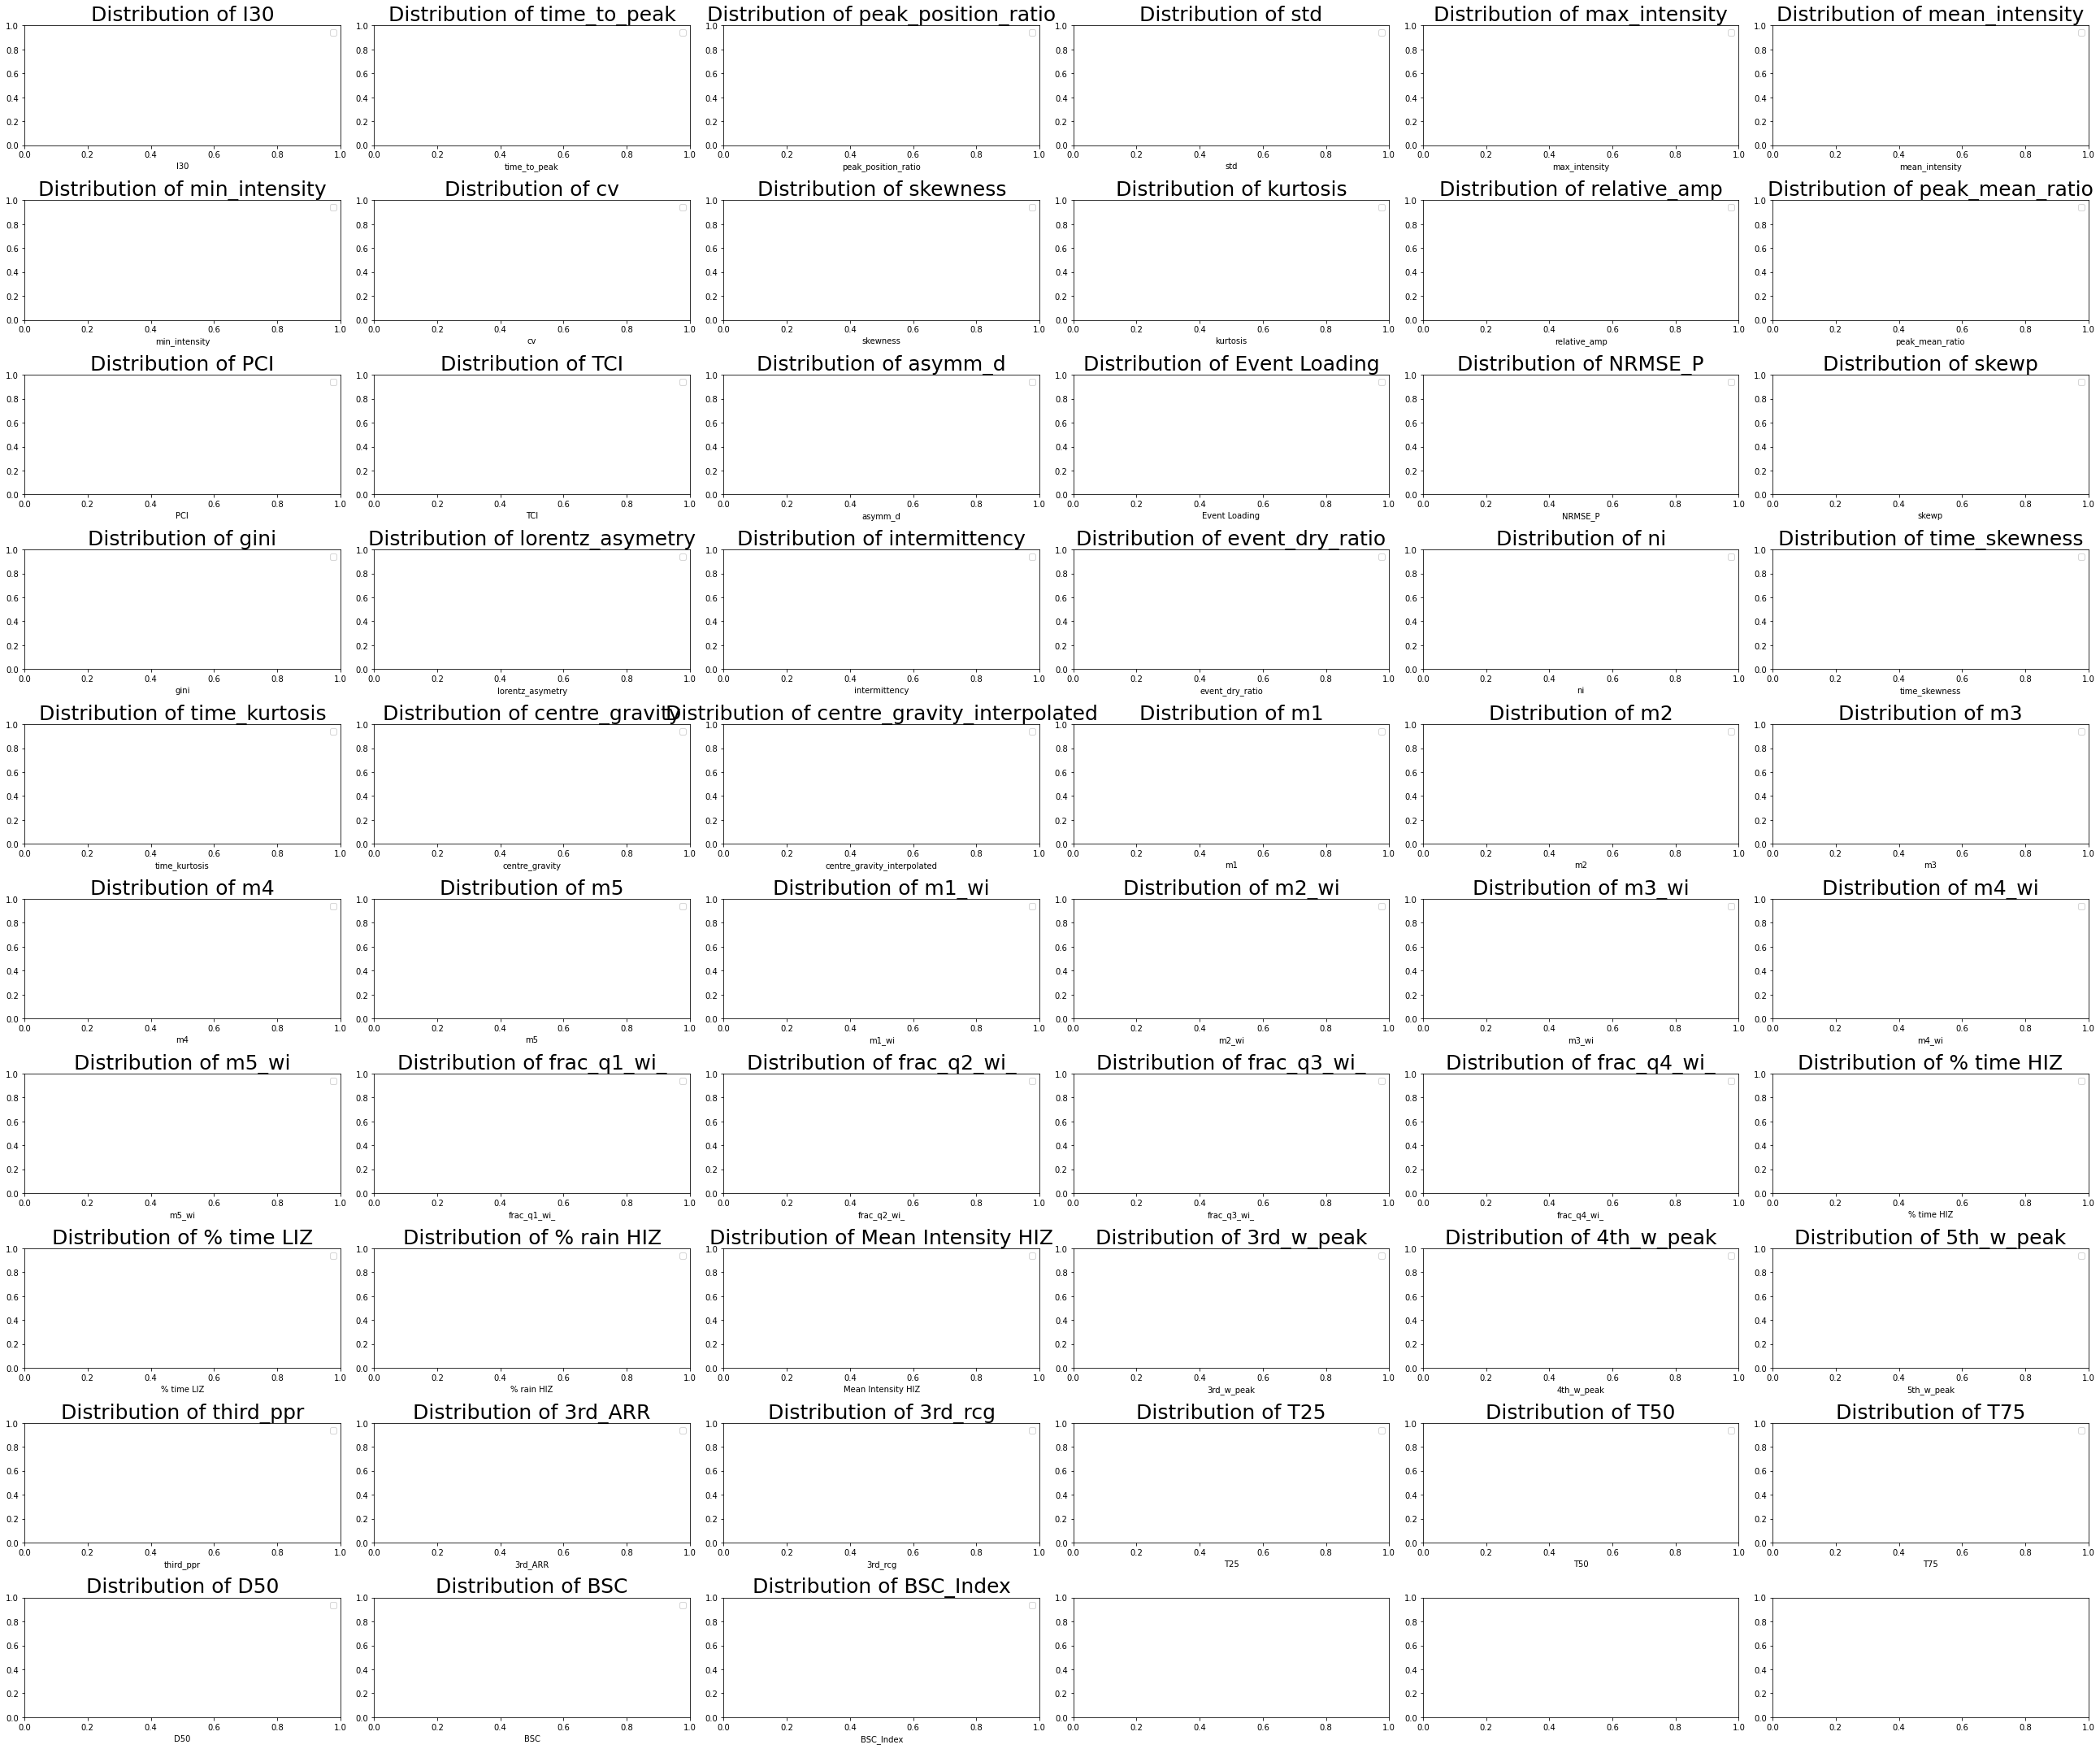

In [214]:
n_metrics = len(metric_columns)

# Define grid shape (e.g., 6 columns per row)
n_cols = 6
n_rows = int(np.ceil(n_metrics / n_cols))

# Define label order and consistent palette
label_order = list(resolutions.keys())
palette = {label: color for label, (df, color) in resolutions.items()}

# Combine all data into long format
plot_data = []
for label, (df, color) in resolutions.items():
    for metric in metric_columns:
        temp = df[[f"{metric}_{label}"]].copy()
        temp.columns = ['value']
        temp['metric'] = metric
        temp['label'] = label
        plot_data.append(temp)

long_df = pd.concat(plot_data)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 3), constrained_layout=True)
if len(metric_columns) == 1:
    axes = [axes]

axs = axes.flatten()

for idx, metric in enumerate(metric_columns):
    ax = axs[idx]
   

    ax.set_title(f'Distribution of {metric}', fontsize=25)
    ax.set_xlabel(metric)

    # Set consistent legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    new_handles = []
    for lbl in label_order:
        if lbl in labels:
            i = labels.index(lbl)
            new_labels.append(lbl)
            new_handles.append(handles[i])
    ax.legend(new_handles, new_labels)

plt.tight_layout()
plt.show()
fig.savefig('../Figures/histograms.png', facecolor='white', edgecolor='white')
